In [1]:
# Install uproot to be able open ROOT files
#pip install uproot

# Plots for the Invisible Higgs Decay Simulation Analysis

In [2]:
# Libraries to import the files
import pathlib 
from pathlib import Path
import sys
from collections import defaultdict
import os
from typing import List, Iterable, Union, Literal

# Libraries for Data Analysis
import re
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load ROOT files into Pandas DataFrames

In [3]:
def load_branch(tree,branch):
    '''
    Loads a ROOT branch into a Numpy array
    '''
    return tree[branch].array(library="np")

def load_histograms(file_path: pathlib.Path):

    file = uproot.open(file_path)

    # Import Events
    tree = file["events"]
    metadata = file["Metadata"]
    #df_list = []
    data_dict = {}

    for branch in tree.keys():
        # Each Branch is stored as an Numpy array
        branch_data = load_branch(tree, branch)

        data_dict[branch] = branch_data

        
    # Turn into a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='index')
    df = df.transpose()   # now each original array becomes a row
    
    # -------------------------
    # Load metadata
    # -------------------------
    meta_tree = file["Metadata"]

    # -----------------------
    # Extract metadata values
    # -----------------------
    metadata = {
        "nGenerated": meta_tree["nGenerated"].array(library="np")[0],
        "nSelected": meta_tree["nSelected"].array(library="np")[0],
    }
    
    return df, metadata



def load_and_combine_histograms(file_paths, verbose=True):
    """
    Load multiple files using load_histograms and combine them
    into a single pandas DataFrame, with error handling.

    Parameters
    ----------
    file_paths : list of str
        List of file paths to be loaded.
    verbose : bool
        If True, prints warnings when a file fails to load.

    Returns
    -------
    pd.DataFrame
        Combined DataFrame containing all successfully loaded files.
    """
    dfs = []

    for path in file_paths:
        try:
            df, metadata = load_histograms(path)

            # Get the folder name containing the file
            folder_name = os.path.basename(os.path.dirname(path))
            df["process_id"] = folder_name
            df["process_id"]= df["process_id"].str.strip().str.lower()


            dfs.append(df)

        except Exception as e:
            if verbose:
                print(f"[WARNING] Failed to load '{path}': {e}")

    if not dfs:
        raise RuntimeError("No files were successfully loaded.")

    return pd.concat(dfs, axis=0, ignore_index=True)


def load_and_combine_histograms(file_paths, verbose=True):
    """
    Load multiple ROOT files and return:

    1) Combined event-level DataFrame
    2) Process-level metadata DataFrame
       (one row per process_id with metadata columns)
    """

    event_dfs = []
    metadata_rows = []

    for path in file_paths:
        try:
            df, metadata = load_histograms(path)

            # Process ID from folder name
            process_id = os.path.basename(os.path.dirname(path))
            process_id = process_id.strip().lower()

            # -------------------------
            # Add process_id to events
            # -------------------------
            df["process_id"] = process_id
            event_dfs.append(df)

            # -------------------------
            # Store metadata separately
            # -------------------------
            metadata_row = {
                "process_id": process_id,
                "nGenerated": metadata["nGenerated"],
                "nSelected": metadata["nSelected"],
            }

            metadata_rows.append(metadata_row)

        except Exception as e:
            if verbose:
                print(f"[WARNING] Failed to load '{path}': {e}")

    if not event_dfs:
        raise RuntimeError("No files were successfully loaded.")

    df_events = pd.concat(event_dfs, axis=0, ignore_index=True)
    df_metadata = pd.DataFrame(metadata_rows)

    return df_events, df_metadata


def collect_files(
    root_dir: str | os.PathLike,
    file_type: Literal["root", "slcio"] = "root",
    sample_type: Literal["signal", "background", "both"] = "background",
    max_files: int = 10,
) -> List[str]:
    """
    Recursively collect files of a given type under ``root_dir``.

    Parameters
    ----------
    root_dir : str or Path-like
        The top-level directory to start the search from.
    file_type : {"root", "slcio"}
        File type to search for.
    sample_type : {"signal", "background", "both"}
        Select which samples to collect.
    max_files : int
        Maximum number of files to collect.

    Returns
    -------
    List[str]
        A list of file paths as strings.
    """
    base_path = Path(root_dir).expanduser().resolve()

    if not base_path.is_dir():
        raise NotADirectoryError(f"The supplied path is not a directory: {base_path}")

    pattern = f"*.{file_type}"
    files: List[str] = []

    for p in base_path.rglob(pattern):
        if not p.is_file():
            continue

        is_signal = any("signal" in part.lower() for part in p.parts)

        if sample_type == "signal" and not is_signal:
            continue
        if sample_type == "background" and is_signal:
            continue
        # sample_type == "both" → keep everything

        files.append(str(p))
        if len(files) >= max_files:
            break

    return files



## Loading the Signal and Background data

In [4]:
# Input directory where data folders are located
input_dir = "../output_files/"

# Background files are all files that are located at folders not named "Signal"
background_files = collect_files(input_dir, file_type="root", sample_type="background", max_files=10000)

bg_df, bg_meta_df = load_and_combine_histograms(background_files, verbose=True)




print(len(bg_df))
bg_df.head()

277991


,nCharged,nChargedNonMuon,nTracks,nTracksNonMuon,totalCharge,sumPtChargedNonMuon,nRecoTracks,visibleEnergy,visiblePx,visiblePy,...,dimuon_px,dimuon_py,dimuon_pz,dimuon_pt,missingEnergy,missingPx,missingPy,missingPz,met,process_id
0,29.0,27.0,0.0,0.0,-1.0,1.111444e+09,0.0,283.146820,0.946784,-1.248093,...,-23.506481,-37.914001,-47.485455,44.609711,-33.146820,-0.946784,1.248093,1.827473,1.566568,402215
1,30.0,28.0,0.0,0.0,4.0,1.104474e+09,0.0,238.842941,2.842760,1.255787,...,32.633171,-18.013044,-41.533607,37.274570,11.157059,-2.842760,-1.255787,11.998663,3.107778,402215
2,45.0,43.0,0.0,0.0,1.0,1.119658e+09,0.0,246.094452,8.619310,6.868799,...,-1.515612,-3.704744,-2.257651,4.002775,3.905548,-8.619310,-6.868799,-7.084722,11.021475,402215
3,34.0,32.0,0.0,0.0,0.0,1.118818e+09,0.0,255.091019,1.828642,0.021509,...,66.122124,-26.184568,-52.652775,71.117981,-5.091019,-1.828642,-0.021509,2.615197,1.828769,402215
4,39.0,37.0,0.0,0.0,1.0,1.116874e+09,0.0,243.011139,0.600354,-3.137184,...,-35.162235,-57.474449,-8.635271,67.377258,6.988861,-0.600354,3.137184,-8.585325,3.194112,402215


In [5]:
bg_meta_df.head()

,process_id,nGenerated,nSelected
0,402215,10000,733
1,402140,12800,8311
2,402195,12800,1044
3,402156,10000,1027
4,402213,8400,858


In [6]:
# Signal are located in the folder "Signal"
signal_files = collect_files(input_dir, file_type="root", sample_type="signal", max_files=10000)

sig_df, sig_meta_df = load_and_combine_histograms(signal_files, verbose=True)


print(len(sig_df))
sig_df.head()

2315


,nCharged,nChargedNonMuon,nTracks,nTracksNonMuon,totalCharge,sumPtChargedNonMuon,nRecoTracks,visibleEnergy,visiblePx,visiblePy,...,dimuon_px,dimuon_py,dimuon_pz,dimuon_pt,missingEnergy,missingPx,missingPy,missingPz,met,process_id
0,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,108.703773,9.000523,6.493093,...,9.000523,6.493093,-59.768749,11.098184,141.296234,-9.000523,-6.493093,59.768749,11.098184,signal
1,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,111.047119,47.222763,14.985824,...,46.488998,15.338804,40.651653,48.954121,138.952881,-47.222763,-14.985824,-40.415417,49.543560,signal
2,4.0,2.0,4.0,2.0,0.0,1.067004e+09,4.0,112.995132,-33.206173,43.825897,...,-34.152557,42.369186,28.201370,54.420082,137.004868,33.206173,-43.825897,-27.976820,54.985081,signal
3,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,120.549530,0.694436,-18.137836,...,0.694436,-18.137836,-2.575470,18.151125,129.450470,-0.694436,18.137836,2.575470,18.151125,signal
4,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,107.852509,9.750203,-32.214622,...,9.750203,-32.214622,-45.348415,33.657810,142.147491,-9.750203,32.214622,45.348415,33.657810,signal


In [7]:
sig_meta_df.head()

,process_id,nGenerated,nSelected
0,signal,2388,2315


In [8]:
combined_meta = pd.concat([bg_meta_df,sig_meta_df], axis=0, ignore_index=True)
print(combined_meta.keys())
combined_meta

Index(['process_id', 'nGenerated', 'nSelected'], dtype='object')


,process_id,nGenerated,nSelected
0,402215,10000,733
1,402140,12800,8311
2,402195,12800,1044
3,402156,10000,1027
4,402213,8400,858
...,...,...,...
119,402155,10000,1428
120,402214,10000,196
121,402701,10000,78
122,402192,10000,280


## Remove duplicated Data

In [9]:
def clean_dataframe(df: pd.DataFrame):
    """
    Detect and remove duplicated rows and rows containing null values.

    Parameters
    ----------
    df : pandas.DataFrame
        The original DataFrame to be cleaned.

    Returns
    -------
    cleaned_df : pandas.DataFrame
        DataFrame with duplicates and null‑containing rows removed.
    stats : dict
        Summary statistics:
            - rows_before:      total rows before any cleaning
            - rows_after_dup:   rows after duplicate removal
            - dup_removed:      number of duplicate rows removed
            - null_counts:     dict of null counts per column (before dropping null rows)
            - null_rows_removed: number of rows removed because they contained nulls
            - rows_final:      rows after both duplicate and null removal
            - fraction_removed: overall fraction of rows removed (dup + null)
            - percent_removed:  overall percent of rows removed
    """

    # ------------------------------------------------------------------
    # 1️⃣  Duplicate detection & removal
    # ------------------------------------------------------------------
    rows_before = len(df)

    dup_mask = df.duplicated()
    dup_removed = dup_mask.sum()
    print(f"Number of duplicated rows: {dup_removed}")

    # Keep only the first occurrence of each duplicated row
    df_no_dup = df.loc[~dup_mask].copy()
    rows_after_dup = len(df_no_dup)

    # ------------------------------------------------------------------
    # 2️⃣  Null detection (on the de‑duplicated frame)
    # ------------------------------------------------------------------
    null_counts_series = df_no_dup.isnull().sum()
    # Convert to a plain dict for easier downstream consumption
    null_counts = null_counts_series.to_dict()
    total_null_rows = df_no_dup.isnull().any(axis=1).sum()


    # Drop rows that contain any nulls
    cleaned_df = df_no_dup.dropna().copy()
    rows_final = len(cleaned_df)

    # ------------------------------------------------------------------
    # 3️⃣  Build the statistics dictionary
    # ------------------------------------------------------------------
    total_removed = rows_before - rows_final
    stats = {
        "rows_before": rows_before,
        "rows_after_dup": rows_after_dup,
        "dup_removed": dup_removed,
        "null_counts_per_column": null_counts,
        "null_rows_removed": total_null_rows,
        "rows_final": rows_final,
        "total_removed": total_removed,
        "fraction_removed": total_removed / rows_before if rows_before else 0.0,
        "percent_removed": 100.0 * total_removed / rows_before if rows_before else 0.0,
    }

    # ------------------------------------------------------------------
    # 4️⃣  Informative shape prints (optional)
    # ------------------------------------------------------------------
    print("\nShape before any cleaning :", df.shape)
    print("Shape after duplicate removal :", df_no_dup.shape)
    print("Shape after dropping null rows :", cleaned_df.shape)

    return cleaned_df, stats

In [10]:
nsig_df, sig_stats = clean_dataframe(sig_df)
nbg_df, bkg_stats = clean_dataframe(bg_df)

Number of duplicated rows: 0

Shape before any cleaning : (2315, 37)
Shape after duplicate removal : (2315, 37)
Shape after dropping null rows : (2315, 37)
Number of duplicated rows: 0

Shape before any cleaning : (277991, 37)
Shape after duplicate removal : (277991, 37)
Shape after dropping null rows : (277991, 37)


# Filter the DataFrame to only have rows for process_id with "pol" = "eL.pR"

In [11]:
df = pd.read_csv("mc_tree/combined_cleaned.csv")
filter_df = pd.read_csv("mc_tree/process_id.csv")
# This the number of events generated in the Key4hep code

# 1 Grab the unique process IDs from filter_df
ids_to_keep = filter_df['process_id'].unique()
assert len(filter_df) == len(filter_df['process_id'].unique())

# 2 Filter the larger DataFrame based
filtered_df = df[df['process_id'].isin(ids_to_keep)].copy()
filtered_df.reset_index(drop=True,inplace=True)

print(filtered_df.keys())
cols_to_remove= ['ProducedRate','n_prod', 'n_gen','NbEvents','int.lumi(1/fb)', 'Done %', 'ElogID(s)','ProdIDs of DST and REC files','int_lumi_fb', 'energy_GeV', 'source_url']
filtered_df.drop(columns=cols_to_remove, inplace=True)
filtered_df

Index(['ProducedRate', 'n_prod', 'n_gen', 'process_type', 'pol', 'process_id',
       'NbEvents', 'int.lumi(1/fb)', 'Done %', 'ElogID(s)',
       'ProdIDs of DST and REC files', 'xsect_pb', 'xsect_error_pb',
       'int_lumi_fb', 'energy_GeV', 'source_url'],
      dtype='object')


,process_type,pol,process_id,xsect_pb,xsect_error_pb
0,e1e1h,eL.pR,402001,17.671491,2.280000e-02
1,e2e2h,eL.pR,402003,16.970655,1.380000e-02
2,e3e3h,eL.pR,402005,16.940726,2.060000e-02
3,n1n1h,eL.pR,402007,60.350892,6.200000e-02
4,n23n23h,eL.pR,402009,67.110727,6.340000e-02
...,...,...,...,...,...
118,n23n23h_cc,eL.pR,410002,1.939500,1.832260e-03
119,n23n23h_dd,eL.pR,410005,0.003490,3.296800e-06
120,n23n23h_gg,eL.pR,410006,5.496369,5.192460e-03
121,n23n23h_ss,eL.pR,410003,0.016509,1.559640e-05


# Fix the naming for "process_id"

In [12]:
filtered_df['process_id'] = filtered_df['process_id'].astype(str).str.strip()
combined_meta['process_id'] = combined_meta['process_id'].astype(str).str.strip()

common_ids = set(filtered_df['process_id']).intersection(set(combined_meta['process_id']))
print(f"Number of matching IDs: {len(common_ids)}")
print(f"IDs only in filtered_df : {len(set(filtered_df['process_id']) - common_ids)}")
print(f"IDs only in combined_meta: {len(set(combined_meta['process_id']) - common_ids)}")
set(combined_meta['process_id']) - common_ids

Number of matching IDs: 123
IDs only in filtered_df : 0
IDs only in combined_meta: 1


{'signal'}

In [13]:
# 1️⃣ Ensure both columns are strings and stripped
combined_meta['process_id'] = combined_meta['process_id'].astype(str).str.strip()
filtered_df['process_id']   = filtered_df['process_id'].astype(str).str.strip()

# 2️⃣ Show the mismatched IDs
missing_in_filtered = set(combined_meta['process_id']) - set(filtered_df['process_id'])
missing_in_combined = set(filtered_df['process_id']) - set(combined_meta['process_id'])

print("Only in combined_meta (should match):", missing_in_filtered)
print("Only in filtered_df (extra IDs):", missing_in_combined)

# 3️⃣ If you suspect a prefix/suffix, display a side‑by‑side view
for pid in missing_in_filtered:
    candidates = filtered_df[filtered_df['process_id'].str.contains(pid, na=False)]
    if not candidates.empty:
        print("\nPotential fuzzy match for", pid)
        print(candidates[['process_id']].head())

Only in combined_meta (should match): {'signal'}
Only in filtered_df (extra IDs): set()


# Constants

In [14]:
# Particle Masses
z_mass = 91.1880
z_mass_sigma = 0.0020

h_mass = 125.20
h_mass_sigma = 0.11

# Values extracted from: https://pdg.lbl.gov/2025/tables/contents_tables.html

sigma_ZH = 346.0          # fb (example: eL pR) the cross-setion
BR_H_inv = 0.001 # % the percentage
BR_Z_mumu = 0.03366 # % the percentage
err_BR_Z_mumu = 0.00060 # % the error in percentage
lumi = 250.0             # fb^-1
N_gen = 1_000 # number of generated events

sigma_signal = sigma_ZH * BR_H_inv * BR_Z_mumu # the cross section for the signal event.
weight_signal = sigma_signal * lumi / 2388

# Center-of-Mass Energy
sqrt_s = 250.0

n_bins = 60 # Number of bins in the histogram

# -------------------------------
# After selection
# -------------------------------
N_sel = len(nsig_df)   # number of selected signal events
sigma_stat = np.sqrt(N_sel) * weight_signal # the statistical error in the signal
rel_err_BRZ = err_BR_Z_mumu / BR_Z_mumu
err_sigma_BRZ = rel_err_BRZ * sigma_signal

sigma_total_uncertainty = np.sqrt(sigma_stat**2 + err_sigma_BRZ**2)

print("========== Signal =========")
print(r"Branching Ratio $h \to \text{inv}$ =" ,BR_H_inv)
print(f"Cross-Section = {sigma_signal}")
print(f"Cross-Section Uncertainty = {sigma_total_uncertainty}")
print(f"Weight = {weight_signal:.4e}")

signal_row = {"process_id": "signal", "process_type": "signal", "pol": "eL.pR", "xsect_pb": sigma_signal, "xsect_error_pb": sigma_total_uncertainty}
filtered_df.loc[len(filtered_df)] = signal_row

========== Signal =========
Branching Ratio $h \to \text{inv}$ = 0.001
Cross-Section = 0.011646360000000001
Cross-Section Uncertainty = 0.058664329819810936
Weight = 1.2193e-03


In [15]:
filtered_df = filtered_df.merge(
    combined_meta[['process_id', 'nGenerated', 'nSelected']],
    on='process_id',
    how='left'          # change to 'inner' / 'right' / 'outer' if needed
)

# ------------------------------------------------------------------
# 3️⃣  Verify the result
# ------------------------------------------------------------------
filtered_df

,process_type,pol,process_id,xsect_pb,xsect_error_pb,nGenerated,nSelected
0,e1e1h,eL.pR,402001,17.671491,2.280000e-02,8400,425
1,e2e2h,eL.pR,402003,16.970655,1.380000e-02,8400,5534
2,e3e3h,eL.pR,402005,16.940726,2.060000e-02,8400,1119
3,n1n1h,eL.pR,402007,60.350892,6.200000e-02,8400,434
4,n23n23h,eL.pR,402009,67.110727,6.340000e-02,8400,440
...,...,...,...,...,...,...,...
119,n23n23h_dd,eL.pR,410005,0.003490,3.296800e-06,10600,94
120,n23n23h_gg,eL.pR,410006,5.496369,5.192460e-03,7400,141
121,n23n23h_ss,eL.pR,410003,0.016509,1.559640e-05,10800,95
122,n23n23h_uu,eL.pR,410004,0.000805,7.608000e-07,10600,80


In [16]:
filtered_df["weight"] = (filtered_df["xsect_pb"] * lumi) / filtered_df["nGenerated"]
filtered_df["process_type"]= filtered_df["process_type"].str.strip().str.lower()

filtered_df.to_csv("process_weights.csv",index=False)

filtered_df

,process_type,pol,process_id,xsect_pb,xsect_error_pb,nGenerated,nSelected,weight
0,e1e1h,eL.pR,402001,17.671491,0.0228,8400,425,0.525937
1,e2e2h,eL.pR,402003,16.970655,0.0138,8400,5534,0.505079
2,e3e3h,eL.pR,402005,16.940726,0.0206,8400,1119,0.504188
3,n1n1h,eL.pR,402007,60.350892,0.0620,8400,434,1.796158
4,n23n23h,eL.pR,402009,67.110727,0.0634,8400,440,1.997343


In [17]:
def map_process_group(process_type: str) -> str:
    """
    Map a raw `process_type` string to a human‑readable group name.

    The function now treats any variant that starts with one of the
    inclusive‑Higgs base names (e.g. "e2e2h_aa") as belonging to the
    "Inclusive Higgs" group instead of falling through to "Other".
    """
    # Normalise – strip whitespace and force lower‑case
    pt = process_type.strip().lower()

    # -----------------------------------------------------------------
    # 1  Signal
    # -----------------------------------------------------------------
    if pt == "signal":
        return "Signal"

    # -----------------------------------------------------------------
    # 2  Inclusive Higgs production (base names *and* their variants)
    # -----------------------------------------------------------------
    inclusive_bases = {"e1e1h", "e2e2h", "e3e3h", "n1n1h", "n23n23h", "qqh"}
    
    # If the string is exactly a base name …
    if pt in inclusive_bases:
        return "Inclusive Higgs"

    # -----------------------------------------------------------------
    # 3  Exclusive Higgs decays
    # -----------------------------------------------------------------
    exclusive_bases = {
    'e1e1h_aa', 'e1e1h_az', 'e1e1h_bb', 'e1e1h_cc', 'e1e1h_dd',
    'e1e1h_e2e2', 'e1e1h_e3e3', 'e1e1h_gg', 'e1e1h_ss', 'e1e1h_uu',
    'e1e1h_ww', 'e1e1h_zz', 'e2e2h_aa', 'e2e2h_az', 'e2e2h_bb',
    'e2e2h_cc', 'e2e2h_dd', 'e2e2h_e2e2', 'e2e2h_e3e3', 'e2e2h_gg',
    'e2e2h_ss', 'e2e2h_uu', 'e2e2h_ww', 'e2e2h_zz', 'e3e3h_aa',
    'e3e3h_az', 'e3e3h_bb', 'e3e3h_cc', 'e3e3h_dd', 'e3e3h_e2e2',
    'e3e3h_e3e3', 'e3e3h_gg', 'e3e3h_ss', 'e3e3h_uu', 'e3e3h_ww',
    'e3e3h_zz', 'n1n1h_aa', 'n1n1h_az', 'n1n1h_bb', 'n1n1h_cc',
    'n1n1h_dd', 'n1n1h_e2e2', 'n1n1h_e3e3', 'n1n1h_gg', 'n1n1h_ss',
    'n1n1h_uu', 'n1n1h_ww', 'n1n1h_zz', 'n23n23h_aa', 'n23n23h_az',
    'n23n23h_bb', 'n23n23h_cc', 'n23n23h_dd', 'n23n23h_e2e2',
    'n23n23h_e3e3', 'n23n23h_gg', 'n23n23h_ss', 'n23n23h_uu',
    'n23n23h_ww', 'n23n23h_zz', 'qqh_aa', 'qqh_az', 'qqh_bb',
    'qqh_cc', 'qqh_dd', 'qqh_e2e2', 'qqh_e3e3', 'qqh_gg',
    'qqh_ss', 'qqh_uu', 'qqh_ww', 'qqh_zz'
    }
    # Anything that contains "_h_" somewhere (e.g. "hzz_h_aa")
    # or that ends with a solitary "h" (e.g. "zh") is considered exclusive.
    # Exclusive checks
    if pt in exclusive_bases:
        return "Exclusive Higgs"

    # -----------------------------------------------------------------
    # 4️ Two‑fermion processes
    # -----------------------------------------------------------------
    if pt.startswith("2f"):
        return "Two‑fermion"

    # -----------------------------------------------------------------
    # 5  Four‑fermion from WW / ZZ pair production
    # -----------------------------------------------------------------
    if pt.startswith("4f_ww") or pt.startswith("4f_zz"):
        return "Four‑fermion (WW/ZZ)"

    # -----------------------------------------------------------------
    # 6 Other four‑fermion (single boson, mixed)
    # -----------------------------------------------------------------
    if pt.startswith("4f"):
        return "Four‑fermion (single boson)"

    # -----------------------------------------------------------------
    # 7  Other multi‑fermion
    # -----------------------------------------------------------------
    if pt.startswith("6f") or "xxxx" in pt:
        return "Other multi‑fermion"

    # -----------------------------------------------------------------
    # 8  Fallback
    # -----------------------------------------------------------------
    return "Other"


def map_process_group(process_type: str) -> str:
    """
    Map a raw `process_type` string to a canonical process group name.

    All returned group names are ASCII-only and guaranteed to match
    ProcessColorMap keys exactly.
    """
    if not isinstance(process_type, str):
        return "Other"

    # Normalize input
    pt = process_type.strip().lower()

    # -------------------------------------------------
    # 1. Signal
    # -------------------------------------------------
    if pt == "signal":
        return "Signal"

    # -------------------------------------------------
    # 2. Inclusive Higgs production (no decay specified)
    # -------------------------------------------------
    inclusive_bases = {
        "e1e1h",
        "e2e2h",
        "e3e3h",
        "n1n1h",
        "n23n23h",
        "qqh",
    }

    if pt in inclusive_bases:
        return "Inclusive Higgs"

    # -------------------------------------------------
    # 3. Exclusive Higgs decays (explicit decay channel)
    # -------------------------------------------------
    exclusive_prefixes = (
        "e1e1h_",
        "e2e2h_",
        "e3e3h_",
        "n1n1h_",
        "n23n23h_",
        "qqh_",
    )

    if pt.startswith(exclusive_prefixes):
        return "Exclusive Higgs"

    # -------------------------------------------------
    # 4. Two-fermion processes
    # -------------------------------------------------
    if pt.startswith("2f"):
        return "Two-fermion"

    # -------------------------------------------------
    # 5. Four-fermion from WW / ZZ pair production
    # -------------------------------------------------
    if pt.startswith("4f_ww") or pt.startswith("4f_zz"):
        return "Four-fermion (WW/ZZ)"

    # -------------------------------------------------
    # 6. Other four-fermion (single boson, mixed)
    # -------------------------------------------------
    if pt.startswith("4f"):
        return "Four-fermion (single boson)"

    # -------------------------------------------------
    # 7. Other multi-fermion
    # -------------------------------------------------
    if pt.startswith("6f") or "xxxx" in pt:
        return "Other multi-fermion"

    # -------------------------------------------------
    # 8. Fallback
    # -------------------------------------------------
    return "Other"


def normalize_label(s):
    return (
        str(s)
        .replace("-", "-")
        .replace("–", "-")
        .strip()
    )


class ProcessColorMap:
    def __init__(self, color_map):
        self.color_map = color_map

    def __call__(self, process_group):
        try:
            return self.color_map[process_group]
        except KeyError:
            raise KeyError(
                f"No color defined for process_group='{process_group}'"
            )

PROCESS_GROUPS = {
    "Signal",
    "Inclusive Higgs",
    "Exclusive Higgs",
    "Two-fermion",
    "Four-fermion (WW/ZZ)",
    "Four-fermion (single boson)",
    "Other multi-fermion",
    "Other",
}



process_colors = ProcessColorMap({
    "Signal": "#d62728",                         # red
    "Inclusive Higgs": "#1f77b4",                # blue
    "Exclusive Higgs": "#9467bd",                # cyan (distinct from inclusive)
    "Two-fermion": "#ff7f0e",                    # orange
    "Four-fermion (WW/ZZ)": "#2ca02c",           # green
    "Four-fermion (single boson)": "#17becf",    # light green
    "Other multi-fermion": "#c7c7c7",            # purple
    "Other": "#7f7f7f",                          # gray
})


PROCESS_GROUP_ORDER = [
    "Signal",
    "Inclusive Higgs",
    "Exclusive Higgs",
    "Two-fermion",
    "Four-fermion (WW/ZZ)",
    "Four-fermion (single boson)",
    "Other multi-fermion",
    "Other",

]


filtered_df["process_group"] = filtered_df["process_type"].apply(map_process_group)
unknown = set(filtered_df["process_group"]) - PROCESS_GROUPS
if unknown:
    raise ValueError(f"Unknown process groups detected: {unknown}")

print(filtered_df["process_group"].value_counts())
filtered_df.head()

process_group
Exclusive Higgs                78
Four-fermion (single boson)    12
Four-fermion (WW/ZZ)           10
Other multi-fermion             9
Two-fermion                     8
Inclusive Higgs                 6
Signal                          1
Name: count, dtype: int64


,process_type,pol,process_id,xsect_pb,xsect_error_pb,nGenerated,nSelected,weight,process_group
0,e1e1h,eL.pR,402001,17.671491,0.0228,8400,425,0.525937,Inclusive Higgs
1,e2e2h,eL.pR,402003,16.970655,0.0138,8400,5534,0.505079,Inclusive Higgs
2,e3e3h,eL.pR,402005,16.940726,0.0206,8400,1119,0.504188,Inclusive Higgs
3,n1n1h,eL.pR,402007,60.350892,0.0620,8400,434,1.796158,Inclusive Higgs
4,n23n23h,eL.pR,402009,67.110727,0.0634,8400,440,1.997343,Inclusive Higgs


In [18]:
for g in sorted(filtered_df["process_group"].unique()):
    print(f"{g:20s} -> {process_colors(g)}")


Exclusive Higgs      -> #9467bd
Four-fermion (WW/ZZ) -> #2ca02c
Four-fermion (single boson) -> #17becf
Inclusive Higgs      -> #1f77b4
Other multi-fermion  -> #c7c7c7
Signal               -> #d62728
Two-fermion          -> #ff7f0e


In [19]:
# -------------------------------------------------
# 1️⃣  Make sure the original `filtered_df` is exactly as you saved it
# -------------------------------------------------
# (If you already wrote it to disk you can reload it, which guarantees a single “signal” row)
# filtered_df = pd.read_csv("process_weights.csv")   # <-- uncomment if you saved it earlier

# -------------------------------------------------
# 2️⃣  Append the signal row – but only if it isn’t already there
# -------------------------------------------------
signal_row = {
    "process_id": "signal",
    "process_type": "signal",
    "pol": "eL.pR",
    "xsect_pb": sigma_signal,
    "xsect_error_pb": sigma_total_uncertainty,
    # add any other mandatory columns here (e.g. ProducedRate, n_prod, …) so the row matches the schema
}
# Check whether a row with process_type == "signal" already exists
if not (filtered_df["process_type"] == "signal").any():
    # Append safely
    filtered_df = filtered_df.append(signal_row, ignore_index=True)
else:
    print("A 'signal' row is already present – not adding another one.")

# -------------------------------------------------
# 3️⃣  Build the mask: keep anything with '_' **or** exactly "signal"
# -------------------------------------------------
mask = filtered_df["process_type"].str.contains("_") | (filtered_df["process_type"] == "signal")
cleaned_df = filtered_df[mask].reset_index(drop=True)

# -------------------------------------------------
# 4️⃣  Remove *extra* signal rows that may have slipped in
# -------------------------------------------------
# Keep only the first occurrence of "signal"
cleaned_df = cleaned_df.drop_duplicates(subset=["process_type"], keep="first")
# (If you also want to guarantee a single signal row regardless of other columns,
#  you could drop duplicates on the whole row: cleaned_df = cleaned_df.drop_duplicates())

# -------------------------------------------------
# 5️⃣  Compare the two columns
# -------------------------------------------------
orig_vals   = filtered_df["process_type"].astype(str).unique()
clean_vals  = cleaned_df["process_type"].astype(str).unique()

# a) Values that disappeared after cleaning (should be only the ones without '_' )
removed = set(orig_vals) - set(clean_vals)

# b) Values that are present only in the cleaned version (normally none, but good sanity check)
added   = set(clean_vals) - set(orig_vals)

# c) Frequency tables – useful to see how many “signal” rows you had
orig_counts  = filtered_df["process_type"].value_counts().sort_index()
clean_counts = cleaned_df["process_type"].value_counts().sort_index()

print("\n=== Summary ===")
print(f"Original distinct process_type count : {len(orig_vals)}")
print(f"Cleaned  distinct process_type count : {len(clean_vals)}")
print(f"Removed values (no '_' and not 'signal') : {sorted(removed)}")
print(f"Added values (unexpected)               : {sorted(added)}\n")

print("Original frequencies (top 10)")
print(orig_counts.head(10))
print("\nCleaned frequencies (top 10)")
print(clean_counts.head(10))

# -------------------------------------------------
# 6️⃣  Optional: write the cleaned version back to disk
# -------------------------------------------------
cleaned_df.to_csv("process_weights_cleaned.csv", index=False)

A 'signal' row is already present – not adding another one.

=== Summary ===
Original distinct process_type count : 118
Cleaned  distinct process_type count : 112
Removed values (no '_' and not 'signal') : ['e1e1h', 'e2e2h', 'e3e3h', 'n1n1h', 'n23n23h', 'qqh']
Added values (unexpected)               : []

Original frequencies (top 10)
process_type
2f-lcfi_z_bb       1
2f-lcfi_z_cc       1
2f-lcfi_z_dd       1
2f-lcfi_z_ss       1
2f-lcfi_z_uu       1
2f_z_eehiq         1
2f_z_h             1
2f_z_l             1
4f-lcfi_zz_bbbb    1
4f-lcfi_zz_cccc    1
Name: count, dtype: int64

Cleaned frequencies (top 10)
process_type
2f-lcfi_z_bb       1
2f-lcfi_z_cc       1
2f-lcfi_z_dd       1
2f-lcfi_z_ss       1
2f-lcfi_z_uu       1
2f_z_eehiq         1
2f_z_h             1
2f_z_l             1
4f-lcfi_zz_bbbb    1
4f-lcfi_zz_cccc    1
Name: count, dtype: int64


In [20]:
print(len(cleaned_df))
cleaned_df.head()

112


,process_type,pol,process_id,xsect_pb,xsect_error_pb,nGenerated,nSelected,weight,process_group
0,e1e1h_aa,eL.pR,402106,0.040114,0.000052,10000,0,0.001003,Exclusive Higgs
1,e1e1h_az,eL.pR,402107,0.027037,0.000035,10000,479,0.000676,Exclusive Higgs
2,e1e1h_bb,eL.pR,402101,10.284808,0.013270,10000,657,0.257120,Exclusive Higgs
3,e1e1h_cc,eL.pR,402102,0.510706,0.000659,10000,266,0.012768,Exclusive Higgs
4,e1e1h_dd,eL.pR,402703,0.000919,0.000001,10000,89,0.000023,Exclusive Higgs


In [21]:


# -------------------------------------------------
# 2️⃣  Helper that performs the comparison for ONE base name
# -------------------------------------------------
def check_process_sum(df: pd.DataFrame, base_name: str, tol_rel: float = 1e-10):
    """
    Parameters
    ----------
    df : pd.DataFrame
        Must contain the columns ``process_type`` and ``xsect_pb``.
    base_name : str
        e.g. "e2e2h". The function will look for rows that start with
        ``base_name + '_'`` (the variants) and for the exact row ``base_name``.
    tol_rel : float, optional
        Relative tolerance used when comparing the summed variant value
        to the original value (defaults to 1e‑12).

    Returns
    -------
    dict
        {
            "base": base_name,
            "original_xsect": float,
            "variant_sum": float,
            "diff": float,
            "within_tol": bool,
            "n_variants": int,
            "variant_details": pd.DataFrame   # optional, can be omitted later
        }
    """
    # ----- original (non‑underscored) row ------------------------------------
    orig_row = df[df["process_type"] == base_name]
    if orig_row.empty:
        raise ValueError(f"No row with process_type == '{base_name}' found.")
    orig_xsect = orig_row.iloc[0]["xsect_pb"]

    # ----- all variant rows (base_name_*) -----------------------------------
    variant_mask = df["process_type"].str.startswith(f"{base_name}_")
    variants = df[variant_mask]

    # Sum the cross‑sections of the variants
    variant_sum = variants["xsect_pb"].sum()
    n_variants = len(variants)

    # ----- tolerance check ---------------------------------------------------
    tol = tol_rel * max(abs(variant_sum), abs(orig_xsect))
    within_tol = np.abs(variant_sum - orig_xsect) <= tol
    diff = variant_sum - orig_xsect

    # Return a compact dictionary (you can turn the list of dicts into a DataFrame later)
    return {
        "base": base_name,
        "original_xsect": orig_xsect,
        "variant_sum": variant_sum,
        "diff": diff,
        "within_tol": within_tol,
        "n_variants": n_variants,
        "variant_details": variants[["process_type", "xsect_pb"]].reset_index(drop=True),
    }

# -------------------------------------------------
# 3️⃣  Run the check for every base process you care about
# -------------------------------------------------
bases = ["e1e1h", "e2e2h", "e3e3h", "n1n1h", "n23n23h", "qqh"]

results = []
for b in bases:
    try:
        res = check_process_sum(filtered_df, b)
        results.append(res)
    except Exception as e:
        print(f"⚠️  Problem with base '{b}': {e}")

# -------------------------------------------------
# 4️⃣  Summarise the outcome in a nice table
# -------------------------------------------------
summary = pd.DataFrame([
    {
        "Process": r["base"],
        r"$n$ variants": r["n_variants"],
        r"$\sigma$ (pb)": r["original_xsect"],
        r"$\sum\sigma$ (pb)": r["variant_sum"],
        r"$\Delta$ (pb)": r["diff"],
    }
    for r in results
])

print("\n=== Cross‑section consistency check ===")
print(summary.to_string(index=False))

# -------------------------------------------------
# 5️⃣  (Optional) Inspect the detailed breakdown for any process
# -------------------------------------------------
# Example: look at the variant contributions for e2e2h
#print(results[1]["variant_details"])


=== Cross‑section consistency check ===
Process  $n$ variants  $\sigma$ (pb)  $\sum\sigma$ (pb)  $\Delta$ (pb)
  e1e1h            12      17.671491          17.671986       0.000495
  e2e2h            12      16.970655          16.971130       0.000475
  e3e3h            12      16.940726          16.941200       0.000474
  n1n1h            12      60.350892          60.352582       0.001690
n23n23h            18      67.110727         113.627722      46.516995
    qqh            12     343.030230         343.039835       0.009605


In [22]:
def sci_latex(x, precision=2):
    """Format number in LaTeX scientific notation."""
    if x == 0:
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / 10**exp
    return rf"${mant:.{precision}f}\times10^{{{exp}}}$"

def format_xsect_summary_df(df):
    df_fmt = df.copy()
    
    # --- PROCESS NAME ------------------------------------------
    if "Process" in df_fmt.columns:
        df_fmt["Process"] = df_fmt["Process"].apply(
            lambda x: rf"\texttt{{{x}}}"
        )
    # --- NUMBER OF VARIANTS ------------------------------------
    if r"$n$ variants" in df_fmt.columns:
        df_fmt[r"$n$ variants"] = df_fmt[r"$n$ variants"].astype(int)

    # --- CROSS SECTIONS ----------------------------------------
    for col in [r"$\sigma$ (pb)", r"$\sum\sigma$ (pb)"]:
        if col in df_fmt.columns:
            df_fmt[col] = df_fmt[col].apply(
                lambda x: sci_latex(x, precision=3)
                if (abs(x) < 1e-3 or abs(x) >= 1e3)
                else f"{x:.3f}"
            )

    # --- DIFFERENCE (ALWAYS SCI NOTATION) ----------------------
    if r"$\Delta$ (pb)" in df_fmt.columns:
        df_fmt[r"$\Delta$ (pb)"] = df_fmt[r"$\Delta$ (pb)"].apply(
            lambda x: sci_latex(x, precision=3)
        )

    return df_fmt

print(format_xsect_summary_df(summary).to_latex(index=False))#, float_format="%.3f")

\begin{tabular}{lrlll}
\toprule
Process & $n$ variants & $\sigma$ (pb) & $\sum\sigma$ (pb) & $\Delta$ (pb) \\
\midrule
\texttt{e1e1h} & 12 & 17.671 & 17.672 & $4.948\times10^{-4}$ \\
\texttt{e2e2h} & 12 & 16.971 & 16.971 & $4.752\times10^{-4}$ \\
\texttt{e3e3h} & 12 & 16.941 & 16.941 & $4.743\times10^{-4}$ \\
\texttt{n1n1h} & 12 & 60.351 & 60.353 & $1.690\times10^{-3}$ \\
\texttt{n23n23h} & 18 & 67.111 & 113.628 & $4.652\times10^{1}$ \\
\texttt{qqh} & 12 & 343.030 & 343.040 & $9.605\times10^{-3}$ \\
\bottomrule
\end{tabular}



Saved figure: event_weights.png


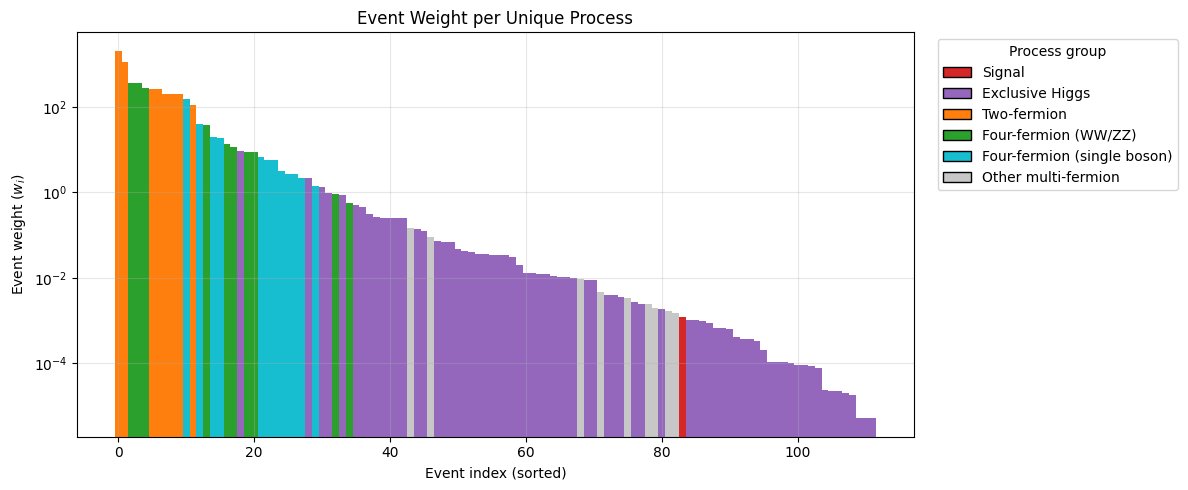

In [23]:
def plot_event_weights_bar(
    df,
    *,
    weight_col="weight",
    group_col="process_group",
    signal_tag="Signal",
    title="Event weight vs. event index",
    xlabel="Event index (sorted)",
    ylabel="Event weight",
    save_path=None,
):
    # -------------------------------------------------
    # Sort by descending weight (important for readability)
    # -------------------------------------------------
    df_sorted = df.sort_values(by=weight_col, ascending=False).reset_index(drop=True)

    x_vals = df_sorted.index.to_numpy()
    y_vals = df_sorted[weight_col].to_numpy()

    # Color mapping via ProcessColorMap
    colors = df_sorted[group_col].apply(
        lambda g: process_colors(g)
    ).to_numpy()

    # -------------------------------------------------
    # Plot
    # -------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.bar(
        x_vals,
        y_vals,
        color=colors,
        width=1.0,
        linewidth=0,
    )


    # -------------------------------------------------
    # Axes styling
    # -------------------------------------------------
    ax.set_yscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.grid(alpha=0.3, which="both")

    # -------------------------------------------------
    # Legend (fixed order, fixed colors)
    # -------------------------------------------------
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    legend_handles = [
        Patch(
            facecolor=process_colors(group),
            edgecolor="black",
            label=group,
        )
        for group in PROCESS_GROUP_ORDER
        if group in df_sorted[group_col].unique()
    ]


    ax.legend(
        handles=legend_handles,
        title="Process group",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=True,
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved figure: {save_path}")

    plt.show()

plot_event_weights_bar(
    cleaned_df,
    weight_col="weight",
    group_col="process_group",
    signal_tag="Signal",
    title="Event Weight per Unique Process",
    xlabel="Event index (sorted)",
    ylabel=r"Event weight ($w_{i}$)",
    save_path="event_weights.png",
)

### Check the size and if both have the same columns

In [24]:
print(f"Signal DataFrame size: {len(nsig_df)} row(s).")
print(f"Background DataFrame size: {len(nbg_df)} row(s).")
print("Columns from the DataFrame")
print(nsig_df.keys())
print()
print(f"Does the Signal and Background DataFrames have the same columns: {list(nsig_df.columns) == list(nbg_df.columns)}")

Signal DataFrame size: 2315 row(s).
Background DataFrame size: 277991 row(s).
Columns from the DataFrame
Index(['nCharged', 'nChargedNonMuon', 'nTracks', 'nTracksNonMuon',
       'totalCharge', 'sumPtChargedNonMuon', 'nRecoTracks', 'visibleEnergy',
       'visiblePx', 'visiblePy', 'visiblePz', 'visiblePt', 'invMass',
       'recoilMass', 'totalEnergy', 'mu1_E', 'mu1_px', 'mu1_py', 'mu1_pz',
       'mu1_pt', 'mu1_charge', 'mu2_E', 'mu2_px', 'mu2_py', 'mu2_pz', 'mu2_pt',
       'mu2_charge', 'dimuon_px', 'dimuon_py', 'dimuon_pz', 'dimuon_pt',
       'missingEnergy', 'missingPx', 'missingPy', 'missingPz', 'met',
       'process_id'],
      dtype='object')

Does the Signal and Background DataFrames have the same columns: True


## Visualing the Dataset Compoistion

In [25]:
def process_group_composition_full(
    df,
    process_group_col="process_group",
):
    """
    Compute the full (unaggregated) composition of the dataframe
    grouped by physics process category.

    Parameters
    ----------
    df : pandas.DataFrame
        Filtered dataframe (after selection).
    process_group_col : str
        Column identifying the physics process group.

    Returns
    -------
    pandas.DataFrame
        Table with event counts and percentages per process group.
    """
    counts = df[process_group_col].value_counts()
    total = counts.sum()

    comp = (
        counts
        .to_frame(name="events")
        .assign(percentage=lambda x: 100 * x["events"] / total)
        .sort_values("percentage", ascending=False)
    )

    # Must be equal
    assert comp["events"].sum() == len(df)

    return comp




def source_file_composition(
    df,
    source_col="process_id",
    process_col="process_type",
    min_fraction=1.0,
    signal_label="signal",
    other_label="Other backgrounds",
    other_process_label="Other backgrounds",
):
    """
    Aggregate small background contributors (< min_fraction %) into a single
    category, while never aggregating signal.

    Intended for plotting / presentation ONLY.
    """
    comp = source_file_composition_full(
        df,
        source_col=source_col,
        process_col=process_col,
    )

    # Separate signal explicitly (by index = source_file name)
    is_signal = comp.index == signal_label

    signal = comp[is_signal]
    backgrounds = comp[~is_signal]

    major_bg = backgrounds[backgrounds["percentage"] >= min_fraction]
    minor_bg = backgrounds[backgrounds["percentage"] < min_fraction]

    if minor_bg.empty:
        return comp

    other = pd.DataFrame(
        {
            "events": [minor_bg["events"].sum()],
            "percentage": [minor_bg["percentage"].sum()],
            "process_type": [other_process_label],
        },
        index=[other_label],
    )

    return pd.concat([signal, major_bg, other])



def plot_composition(
    composition_df,
    *,
    percentage_col="percentage",
    process_group_col="process_group",
    signal_group="Signal",
    annotation=False,
    title=r"Dataset composition for $80 < m_{\mu\mu} < 100$ GeV",
    ylabel="Fraction [%]",
    save_path="dataset_composition.png",
):
    """
    Plot dataset composition grouped by physics process category.

    Parameters
    ----------
    composition_df : pd.DataFrame
        Index = process_group
        Column `percentage_col` contains percentage contribution.
    """

    # -------------------------------------------------
    # Sort by descending contribution
    # -------------------------------------------------
    df = composition_df.sort_values(percentage_col, ascending=False)

    process_groups = df.index.tolist()

    # -------------------------------------------------
    # Fixed color mapping
    # -------------------------------------------------
    colors = [
    process_colors(pg)
    for pg in process_groups
    ]



    # -------------------------------------------------
    # Plot
    # -------------------------------------------------
    plt.figure(figsize=(10, 4.5))
    
    bars = plt.bar(
        process_groups,
        df[percentage_col],
        color=colors,
        edgecolor="black",
        linewidth=0.6,
    )


    # -------------------------------------------------
    # Annotate percentages
    # -------------------------------------------------
    if annotation:
        ax = plt.gca()
    
        ymax = ax.get_ylim()[1]
        min_visible = 0.1        # [%] below this → skip or move
        top_margin = 0.02 * ymax # 2% headroom
    
        for bar, value in zip(bars, df[percentage_col]):
            height = bar.get_height()
            
            if value < min_visible:
                print(value)
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.02 * ymax,
                    "<0.1%",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    color="gray",
                    clip_on=True,
                )

            elif value > min_visible:
                # Decide placement
                if height > 0.85 * ymax:
                    # Very tall bar → put text inside
                    y = height - 0.03 * ymax
                    va = "top"
                else:
                    # Normal case → above bar
                    y = min(height + 0.02 * ymax, ymax - top_margin)
                    va = "bottom"
    
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    y,
                    f"{value:.1f}%",
                    ha="center",
                    va=va,
                    fontsize=8,
                    clip_on=True,
                )

    # -------------------------------------------------
    # Labels & styling
    # -------------------------------------------------
    plt.ylabel(ylabel)
    plt.xlabel("Physics Process Category")
    plt.title(title)

    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)

    # -------------------------------------------------
    # Legend (only categories that appear)
    # -------------------------------------------------
    from matplotlib.patches import Patch
    
    legend_handles = [
        Patch(
            facecolor=process_colors(pg),
            edgecolor="black",
            label=pg,
        )
        for pg in process_groups
    ]
    
    plt.legend(
        handles=legend_handles,
        frameon=True,
        fontsize=9,
        ncol=2,
    )


    # -------------------------------------------------
    # Save & show
    # -------------------------------------------------
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


def acceptance_efficiency(
    comp_df,
    n_generated=1_000_000,
):
    """
    Compute acceptance and efficiency from a composition dataframe.

    Parameters
    ----------
    comp_df : pandas.DataFrame
        Output of source_file_composition_full().
        Must contain an 'events' column.
    n_generated : int or dict
        If int: same N_generated for all processes.
        If dict: per-process N_generated, keyed by source_file.

    Returns
    -------
    pandas.DataFrame
        Table with N_selected, N_generated, acceptance, efficiency.
    """
    result = comp_df.copy()
    result = result.rename(columns={"events": "N_selected"})

    if isinstance(n_generated, dict):
        result["N_generated"] = result.index.map(n_generated)
    else:
        result["N_generated"] = n_generated

    if result["N_generated"].isna().any():
        raise ValueError("Missing N_generated for one or more processes")

    result["efficiency"] = result["N_selected"] / result["N_generated"]

    # Efficiency bounds
    assert (result["efficiency"] <= 1.0).all()

    return result



In [26]:
def filter_between(arr, col, low, high):
    """
    Filter the array between two values
    """
    filtered = arr[(arr[col] >= low) & (arr[col] <= high)]

    return filtered

def find_min_max(df):
    """
    Returns the min and max values for the numeric columns in a df
    """
    
    numeric_df = df.select_dtypes(include='number')
    col_mins = numeric_df.min()
    col_maxs = numeric_df.max()

    return col_mins, col_maxs

def limits(df, col):
    """
    Return the rounded Lowest and Highest values for column in a DataFrame
    """
    min_values, max_values = find_min_max(df)
    lower, upper = nice_limits(min_values[col], max_values[col], base=10)
    print(f"Lowest Value for {col}: {min_values[col]}")
    print(f"Lowest Value for {col}: {max_values[col]}")
    print(f"Rounded Lower Limit: {lower}")
    print(f"Rounded Upper Limit: {upper}")

    return lower, upper

def nice_limits(min_val, max_val, base=1):
    """
    Round min down and max up to the nearest multiple of `base`.
    """
    lower = np.floor(min_val / base) * base
    upper = np.ceil(max_val / base) * base
    return lower, upper


def abs_window(df, col, val, delta_mz=10.0):
    """
    Keep rows for which |df[col] – val| < delta_mz.

    Parameters
    ----------
    df : pandas.DataFrame
        Input table.
    col : str
        Column name that holds the quantity to compare (e.g. “m_mumu”).
    val : float
        Target value (e.g. the Z‑boson mass).
    delta_mz : float, optional
        Half‑width of the allowed window.  Default is 10.0.

    Returns
    -------
    pandas.DataFrame
        Sub‑set of ``df`` that satisfies the absolute‑difference condition.
    """
    # 1️⃣  Build the boolean mask
    mask = np.abs(df[col] - val) < delta_mz

    # 2️⃣  Count and report how many rows survive
    n_before = len(df)
    n_after  = mask.sum()               # number of True entries
    print(f"Rows before cut: {n_before:,d} → after cut: {n_after:,d}")

    # 3️⃣  Return the filtered DataFrame
    return df[mask]

def fom(
    df,
    *,
    source_col="process_id",
    signal_tag="signal",
    weight_col="weight",
):
    """
    Calculates the Figure of Merit using weighted yields:
        FOM = S / sqrt(S + B)

    If weight_col exists, weighted yields are used.
    Otherwise, unweighted event counts are used.
    """

    sig_df = df[df[source_col] == signal_tag]
    bg_df  = df[df[source_col] != signal_tag]

    use_weights = weight_col in df.columns

    if use_weights:
        S = sig_df[weight_col].sum()
        B = bg_df[weight_col].sum()
    else:
        S = len(sig_df)
        B = len(bg_df)

    if S + B <= 0:
        raise ValueError("S + B must be > 0")

    FOM = S / np.sqrt(S+B)
    sb = S / B

    print(f"Signal yield:       {S:.4f}")
    print(f"Background yield:   {B:.4f}")
    print(f"Total yield:        {S + B:.4f}")
    print(f"Signal fraction:    {100 * S / (S + B):.4f}%")
    print(f"S/B:                {sb:.4f}")
    print(f"FOM:                {FOM:.4f}")

    return FOM, sb

def cut_all(df):
    return df

def cut_lepton_pt(df, thr=10):
    return df[(df["mu1_pt"] > thr) & (df["mu2_pt"] > thr)].copy()

def cut_p_T(df, low=20, high=70):
    return df[(df["visiblePt"] > low) & (df["visiblePt"] < high)].copy()

def cut_z_mass(df, low=0.0, high=10.0, mass_col="invMass"):
    """
    Select events based on |m_Z_candidate - m_Z|.
    """
    return df[
        np.abs(df[mass_col] - z_mass).between(low, high)
    ]


def cut_higgs_window(df, low=0.0, high=5.0, mass_col="recoilMass"):
    """
    Select events based on |m_H_candidate - m_H|.
    """
    return df[
        np.abs(df[mass_col] - h_mass).between(low, high)
    ]



def cut_missing_energy(df, thr=20):
    return df[df["missingEnergy"] > thr].copy()



cuts = [
    ("All events", cut_all),
    ("Lepton pt", cut_lepton_pt),
    ("Transverse Momentum", cut_p_T),
    #("Missing Transverse Momentum", cut_missing_pt),
    ("Z mass window", cut_z_mass),
    ("Higgs recoil window", cut_higgs_window),
    ("Missing energy", cut_missing_energy),
]

def build_cutflow(
    df,
    cuts,
    *,
    source_col="process_id",
    signal_tag="signal",
    weight_col="weight",
):
    """
    Build cut-flow tables for signal and background.

    Returns
    -------
    df_yields : pandas.DataFrame
        Table with yields and efficiencies:
        Cut | S | B | ε | R

    df_performance : pandas.DataFrame
        Table with performance metrics:
        Cut | S/B | S/sqrt(S+B)
    """

    rows_yields = []
    rows_perf = []

    # -------------------------------------------------
    # Split signal / background
    # -------------------------------------------------
    sig_df = df[df[source_col] == signal_tag].copy()
    bkg_df = df[df[source_col] != signal_tag].copy()

    sig_current = sig_df
    bkg_current = bkg_df

    # -------------------------------------------------
    # Decide whether to use weights
    # -------------------------------------------------
    use_weights = weight_col is not None and weight_col in df.columns

    if use_weights:
        sig_initial = sig_df[weight_col].sum()
        bkg_initial = bkg_df[weight_col].sum()
    else:
        sig_initial = len(sig_df)
        bkg_initial = len(bkg_df)

    # -------------------------------------------------
    # Apply cuts sequentially
    # -------------------------------------------------
    for name, cut in cuts:
        sig_current = cut(sig_current)
        bkg_current = cut(bkg_current)

        if use_weights:
            sig_yield = sig_current[weight_col].sum()
            bkg_yield = bkg_current[weight_col].sum()
        else:
            sig_yield = len(sig_current)
            bkg_yield = len(bkg_current)

        # --- Table 1: yields & efficiencies
        rows_yields.append({
            "Cut": name,
            r"$S$": sig_yield,
            r"$B$": bkg_yield,
            r"$\epsilon$": sig_yield / sig_initial if sig_initial > 0 else 0.0,
            r"$R$": bkg_yield / bkg_initial if bkg_initial > 0 else 0.0,
        })

        # --- Table 2: performance
        denom = sig_yield + bkg_yield
        rows_perf.append({
            "Cut": name,
            r"$S/B$": sig_yield / bkg_yield if bkg_yield > 0 else 0.0,
            r"$S/\sqrt{S+B}$": sig_yield / np.sqrt(denom) if denom > 0 else 0.0,
        })

    df_yields = pd.DataFrame(rows_yields)
    df_performance = pd.DataFrame(rows_perf)

    return df_yields, df_performance


def build_cut_evolution(cutflow_df):
    """
    Build a table describing the step-by-step evolution of
    Efficiency, Rejection and Figure of Merit.

    Parameters
    ----------
    cutflow_df : pandas.DataFrame
        Output of build_cutflow()

    Returns
    -------
    pandas.DataFrame
        Table with relative changes per cut.
    """

    rows = []

    # Extract columns (safe against LaTeX names)
    eff_col = r"$\epsilon$"
    rej_col = r"$R$"
    sb_col  = r"$S/B$"
    fom_col = r"$S/\sqrt{S+B}$"

    prev_eff = None
    prev_rej = None
    prev_sb  = None
    prev_fom = None

    for _, row in cutflow_df.iterrows():
        cut = row["Cut"]
        eff = row[eff_col]
        rej = row[rej_col]
        sb  = row[sb_col]
        fom = row[fom_col]

        if prev_eff is None:
            # First row = reference
            rows.append({
                "Cut": cut,
                r"$\Delta \epsilon$": 0.0,
                r"$R_{\mathrm{step}}$": 1.0,
                r"$S/B$": 1.0,
                r"$\times$ FoM": 1.0,
            })
        else:
            rows.append({
                "Cut": cut,
                r"$\Delta \epsilon$": eff / prev_eff - 1.0,
                r"$R_{\mathrm{step}}$": prev_rej / rej if rej > 0 else np.inf,
                r"$S/B$": rej / prev_rej if prev_rej > 0 else np.inf,
                r"$\times$ FoM": fom / prev_fom if prev_fom > 0 else np.inf,
            })

        prev_eff = eff
        prev_rej = rej
        prev_sb  = sb
        prev_fom = fom

    return pd.DataFrame(rows)


def apply_cuts_with_history(df, cuts, fom):
    """
    Apply cuts sequentially, store DataFrames after each cut,
    and evaluate a figure of merit after each step.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset.
    cuts : list of (str, callable)
        List of (cut_name, cut_function) pairs.
    fom : callable
        Function taking a DataFrame and returning a scalar FOM.

    Returns
    -------
    history : dict
        Dictionary {cut_name: DataFrame_after_cut}
    fom_values : list
        List of FOM values after each cut (same order as cuts).
    """
    history = {}
    fom_values = []
    sb_values = []

    current = df.copy()

    for name, cut in cuts:
        current = cut(current)
        history[name] = current.copy()

        # Evaluate FOM after this cut
        fom_value, sb_value = fom(current)
        fom_values.append(fom_value)
        sb_values.append(sb_value)

    return history, fom_values, sb_values



In [27]:
# Combining the Signal and Background DataFrames
combined = pd.concat([nsig_df,nbg_df], axis=0, ignore_index=True)
combined

,nCharged,nChargedNonMuon,nTracks,nTracksNonMuon,totalCharge,sumPtChargedNonMuon,nRecoTracks,visibleEnergy,visiblePx,visiblePy,...,dimuon_px,dimuon_py,dimuon_pz,dimuon_pt,missingEnergy,missingPx,missingPy,missingPz,met,process_id
0,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,108.703773,9.000523,6.493093,...,9.000523,6.493093,-59.768749,11.098184,141.296234,-9.000523,-6.493093,59.768749,11.098184,signal
1,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,111.047119,47.222763,14.985824,...,46.488998,15.338804,40.651653,48.954121,138.952881,-47.222763,-14.985824,-40.415417,49.543560,signal
2,4.0,2.0,4.0,2.0,0.0,1.067004e+09,4.0,112.995132,-33.206173,43.825897,...,-34.152557,42.369186,28.201370,54.420082,137.004868,33.206173,-43.825897,-27.976820,54.985081,signal
3,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,120.549530,0.694436,-18.137836,...,0.694436,-18.137836,-2.575470,18.151125,129.450470,-0.694436,18.137836,2.575470,18.151125,signal
4,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,107.852509,9.750203,-32.214622,...,9.750203,-32.214622,-45.348415,33.657810,142.147491,-9.750203,32.214622,45.348415,33.657810,signal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280301,32.0,30.0,0.0,0.0,-2.0,1.116434e+09,0.0,148.146866,-43.840355,-33.900604,...,2.512140,-5.000299,-3.503217,5.595877,101.853134,43.840355,33.900604,3.796880,55.418655,402192
280302,39.0,37.0,0.0,0.0,-1.0,1.115706e+09,0.0,137.745041,-32.307125,15.260879,...,-11.573288,16.649712,-6.388609,20.276930,112.254959,32.307125,-15.260879,34.070232,35.730167,402192
280303,22.0,20.0,0.0,0.0,4.0,1.115092e+09,0.0,133.117874,4.619813,33.182705,...,-0.347735,-2.393929,6.106152,2.419053,116.882126,-4.619813,-33.182705,-45.655296,33.502754,402192
280304,41.0,39.0,0.0,0.0,1.0,1.113813e+09,0.0,150.656967,24.031094,20.925827,...,-0.035579,18.105946,7.693809,18.105980,99.343033,-24.031094,-20.925827,42.903572,31.865086,402192


In [28]:
combined.describe()

,nCharged,nChargedNonMuon,nTracks,nTracksNonMuon,totalCharge,sumPtChargedNonMuon,nRecoTracks,visibleEnergy,visiblePx,visiblePy,...,mu2_charge,dimuon_px,dimuon_py,dimuon_pz,dimuon_pt,missingEnergy,missingPx,missingPy,missingPz,met
count,280306.000000,280306.000000,280306.000000,280306.000000,280306.000000,2.803060e+05,280306.000000,280306.000000,280306.000000,280306.000000,...,280306.000000,280306.000000,280306.000000,280306.000000,280306.000000,280306.000000,280306.000000,280306.000000,280306.000000,280306.000000
mean,17.521345,15.521344,0.019072,0.002547,0.042325,1.057737e+09,0.019072,197.734207,1.355858,-0.051020,...,0.000193,0.726504,-0.011812,0.189263,37.073006,52.265797,-1.355858,0.051020,-0.105189,19.762707
std,13.557757,13.557757,0.229269,0.098112,1.805764,1.980884e+08,0.229269,62.309166,20.955318,21.040295,...,1.000002,30.349089,30.402637,42.235638,21.714113,62.309166,20.955318,21.040295,35.851128,22.205730
min,2.000000,0.000000,0.000000,0.000000,-11.000000,0.000000e+00,0.000000,5.186052,-369.445801,-366.234711,...,-1.000000,-184.557251,-367.672821,-486.612122,0.022143,-637.475220,-471.314056,-239.059235,-459.253632,0.017612
25%,7.000000,5.000000,0.000000,0.000000,-1.000000,1.071812e+09,0.000000,145.573246,-2.394326,-3.941801,...,-1.000000,-18.906438,-19.600473,-25.978823,18.732320,-0.749939,-5.339999,-3.866559,-12.370459,2.551458
50%,12.000000,10.000000,0.000000,0.000000,0.000000,1.104660e+09,0.000000,216.296051,1.648907,-0.005287,...,1.000000,1.015702,0.003786,0.089403,39.109583,33.703949,-1.648907,0.005287,-0.036964,8.201729
75%,27.000000,25.000000,0.000000,0.000000,1.000000,1.114893e+09,0.000000,250.749939,5.339999,3.866559,...,1.000000,20.382703,19.684463,26.420271,54.204749,104.426754,2.394326,3.941801,12.280361,33.340873
max,97.000000,95.000000,15.000000,13.000000,14.000000,1.141143e+09,15.000000,887.475220,471.314056,239.059235,...,1.000000,395.559326,154.439621,175.828201,397.133118,244.813950,369.445801,366.234711,606.479980,471.520782


In [29]:
total_simulated = len(filtered_df)*N_gen
print(f"Total Events simulated: {total_simulated}")
selected = len(combined)
percentage_selected = selected/total_simulated
print(f"Total Events selected: {selected}")
print(f"Percentage of Selected Events to Total Events: {percentage_selected}")

Total Events simulated: 124000
Total Events selected: 280306
Percentage of Selected Events to Total Events: 2.260532258064516


# Data Analysis
It's important to check if the process_id and source_file columns have same type

In [30]:
missing_in_filtered = set(combined["process_id"]) - set(filtered_df["process_id"])
missing_in_combined = set(filtered_df["process_id"]) - set(combined["process_id"])

print("\nKeys in combined_df not found in filtered_df:", list(missing_in_filtered)[:10])
print("Keys in filtered_df not found in combined_df:", list(missing_in_combined)[:10])

combined["process_id"] = combined["process_id"].astype(str).str.strip()
filtered_df["process_id"] = filtered_df["process_id"].astype(str).str.strip()


Keys in combined_df not found in filtered_df: []
Keys in filtered_df not found in combined_df: ['402178', '402106']


In [31]:
print("combined_df['process_id'] dtype :", combined["process_id"].dtype)
print("filtered_df['process_id'] dtype :", filtered_df["process_id"].dtype)

combined = combined.merge(
    filtered_df[["process_id","weight","process_type","process_group"]],      # keep only the needed cols
    left_on="process_id",       # column in combined_df
    right_on="process_id",       # column in filtered_df
    how="left",                  # keep all rows from combined_df
    validate="many_to_one"       # optional: ensures each key appears once in filtered_df
)
combined.to_csv("combined.csv",index=False)
combined

combined_df['process_id'] dtype : object
filtered_df['process_id'] dtype : object


,nCharged,nChargedNonMuon,nTracks,nTracksNonMuon,totalCharge,sumPtChargedNonMuon,nRecoTracks,visibleEnergy,visiblePx,visiblePy,...,dimuon_pt,missingEnergy,missingPx,missingPy,missingPz,met,process_id,weight,process_type,process_group
0,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,108.703773,9.000523,6.493093,...,11.098184,141.296234,-9.000523,-6.493093,59.768749,11.098184,signal,0.001219,signal,Signal
1,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,111.047119,47.222763,14.985824,...,48.954121,138.952881,-47.222763,-14.985824,-40.415417,49.543560,signal,0.001219,signal,Signal
2,4.0,2.0,4.0,2.0,0.0,1.067004e+09,4.0,112.995132,-33.206173,43.825897,...,54.420082,137.004868,33.206173,-43.825897,-27.976820,54.985081,signal,0.001219,signal,Signal
3,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,120.549530,0.694436,-18.137836,...,18.151125,129.450470,-0.694436,18.137836,2.575470,18.151125,signal,0.001219,signal,Signal
4,2.0,0.0,2.0,0.0,0.0,0.000000e+00,2.0,107.852509,9.750203,-32.214622,...,33.657810,142.147491,-9.750203,32.214622,45.348415,33.657810,signal,0.001219,signal,Signal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280301,32.0,30.0,0.0,0.0,-2.0,1.116434e+09,0.0,148.146866,-43.840355,-33.900604,...,5.595877,101.853134,43.840355,33.900604,3.796880,55.418655,402192,0.048488,n23n23h_cc,Exclusive Higgs
280302,39.0,37.0,0.0,0.0,-1.0,1.115706e+09,0.0,137.745041,-32.307125,15.260879,...,20.276930,112.254959,32.307125,-15.260879,34.070232,35.730167,402192,0.048488,n23n23h_cc,Exclusive Higgs
280303,22.0,20.0,0.0,0.0,4.0,1.115092e+09,0.0,133.117874,4.619813,33.182705,...,2.419053,116.882126,-4.619813,-33.182705,-45.655296,33.502754,402192,0.048488,n23n23h_cc,Exclusive Higgs
280304,41.0,39.0,0.0,0.0,1.0,1.113813e+09,0.0,150.656967,24.031094,20.925827,...,18.105980,99.343033,-24.031094,-20.925827,42.903572,31.865086,402192,0.048488,n23n23h_cc,Exclusive Higgs


In [32]:
combined.keys()

Index(['nCharged', 'nChargedNonMuon', 'nTracks', 'nTracksNonMuon',
       'totalCharge', 'sumPtChargedNonMuon', 'nRecoTracks', 'visibleEnergy',
       'visiblePx', 'visiblePy', 'visiblePz', 'visiblePt', 'invMass',
       'recoilMass', 'totalEnergy', 'mu1_E', 'mu1_px', 'mu1_py', 'mu1_pz',
       'mu1_pt', 'mu1_charge', 'mu2_E', 'mu2_px', 'mu2_py', 'mu2_pz', 'mu2_pt',
       'mu2_charge', 'dimuon_px', 'dimuon_py', 'dimuon_pz', 'dimuon_pt',
       'missingEnergy', 'missingPx', 'missingPy', 'missingPz', 'met',
       'process_id', 'weight', 'process_type', 'process_group'],
      dtype='object')

In [33]:

# Define the base process names
# -------------------------------------------------
base_names = ["e1e1h", "e2e2h", "e3e3h", "n1n1h", "n23n23h", "qqh"]

# -------------------------------------------------
# 3️⃣  Helper that checks the event‑weight consistency for ONE base name
# -------------------------------------------------
def check_event_weight_sum(df: pd.DataFrame, base: str, rel_tol: float = 1e-12):
    """
    Returns a dict with the original weight, the summed variant weight,
    the absolute difference and a boolean flag indicating whether they match.
    """
    # ---- original row (exact match) -----------------------------------------
    orig_row = df[df["process_type"] == base]
    if orig_row.empty:
        raise ValueError(f"No row with process_type == '{base}' found.")
    orig_w = orig_row.iloc[0]["weight"]

    # ---- variant rows (start with base_ ) ------------------------------------
    variant_mask = df["process_type"].str.startswith(f"{base}_")
    variants = df[variant_mask]

    # Sum the event_weight of the variants
    var_sum = variants["weight"].sum()
    n_variants = len(variants)

    # ---- tolerance check ----------------------------------------------------
    tol = rel_tol * max(abs(orig_w), abs(var_sum))
    within_tol = np.abs(var_sum - orig_w) <= tol
    diff = var_sum - orig_w

    return {
        "base": base,
        "original_weight": orig_w,
        "variant_sum": var_sum,
        "n_variants": n_variants,
        "diff": diff,
        "within_tol": within_tol,
        "variant_details": variants[["process_type", "weight"]].reset_index(drop=True),
    }

# -------------------------------------------------
# 4️⃣  Run the check for every base process
# -------------------------------------------------
results = []
for b in base_names:
    try:
        results.append(check_event_weight_sum(combined, b))
    except Exception as e:
        print(f"⚠️  Problem with '{b}': {e}")

# -------------------------------------------------
# 5️⃣  Summarise the outcome in a readable table
# -------------------------------------------------
summary = pd.DataFrame([
    {
        "process": r["base"],
        "# variants": r["n_variants"],
        "orig event_weight": r["original_weight"],
        "sum variants": r["variant_sum"],
        "Δ": r["diff"],
        "match?": "✅" if r["within_tol"] else "❌",
    }
    for r in results
])

print("\n=== Event‑weight consistency check ===")
print(summary.to_string(index=False))




=== Event‑weight consistency check ===
process  # variants  orig event_weight  sum variants           Δ match?
  e1e1h       12546           0.525937    155.534790  155.008853      ❌
  e2e2h      100449           0.505079   2792.774579 2792.269500      ❌
  e3e3h       15207           0.504188    337.160362  336.656174      ❌
  n1n1h       13086           1.796158    519.556399  517.760241      ❌
n23n23h       13704           1.997343    908.558149  906.560806      ❌
    qqh       11483          15.313850   5017.512464 5002.198614      ❌


In [34]:
# --------------------------------------
# Define the six base process names
# --------------------------------------
base_names = ["e1e1h", "e2e2h", "e3e3h", "n1n1h", "n23n23h", "qqh"]

# --------------------------------------
# Create masks
# --------------------------------------

# a) Original (exact base names)
orig_mask = combined["process_type"].isin(base_names)

# b) Variant (starts with <base> + '_')
variant_mask = combined["process_type"].apply(
    lambda pt: any(pt.startswith(b + "_") for b in base_names)
)

# c) Signal
signal_mask = combined["process_type"] == "signal"

# d) Background — everything else
background_mask = ~(orig_mask | variant_mask | signal_mask)

# Sanity check — all rows are categorized
assert (orig_mask | variant_mask | signal_mask | background_mask).all()

# Sanity check: masks are pairwise disjoint
assert not (orig_mask & variant_mask).any()
assert not (orig_mask & signal_mask).any()
assert not (variant_mask & signal_mask).any()

# --------------------------------------
# Split into DataFrames
# --------------------------------------
orig_df       = combined[orig_mask].copy()
variant_df    = combined[variant_mask].copy()
signal_df     = combined[signal_mask].copy()
bkg_df = combined[background_mask].copy()

# Now lengths must add up
total = len(orig_df) + len(variant_df) + len(signal_df) + len(bkg_df)
assert total == len(combined), f"{total} != {len(combined)}"


# -------------------------------------------------
# 5  Verify the link via process_id ↔ source_file
# -------------------------------------------------
def _check_link(df_split, name):
    mismatches = ~df_split["process_id"].eq(df_split["process_id"])
    if mismatches.any():
        print(f"⚠️  {name}: {mismatches.sum()} rows have mismatched IDs.")
    else:
        print(f"✅  {name}: All rows have matching process_id ↔ source_file.")

_check_link(orig_df,    "original")
_check_link(variant_df, "variant‑sum")
_check_link(signal_df,  "signal")

# -------------------------------------------------
# 6  (Optional) Save the three halves for later use
# -------------------------------------------------
orig_df.to_csv("combined_original_rows.csv", index=False)
variant_df.to_csv("combined_variant_rows.csv", index=False)
signal_df.to_csv("combined_signal_rows.csv", index=False)


✅  original: All rows have matching process_id ↔ source_file.
✅  variant‑sum: All rows have matching process_id ↔ source_file.
✅  signal: All rows have matching process_id ↔ source_file.


In [35]:
orig_plus_signal = pd.concat([orig_df, signal_df], ignore_index=True)
dataset_df = pd.concat([variant_df, signal_df, bkg_df], ignore_index=True)
print(len(orig_plus_signal))
print(len(dataset_df))

print(total == len(combined))

9686
272935
True


# Cut-flow table

In [36]:
df_yields, df_performance = build_cutflow(dataset_df, cuts)

def to_latex_scientific(x, sig=6):
    """Return a LaTeX string for x in scientific notation."""
    mantissa, exp = f"{x:.{sig}e}".split('e')
    return f"${mantissa} \\times 10^{{{int(exp)}}}$"




def format_cutflow_df(df):
    df_fmt = df.copy()

    # --- YIELDS -------------------------------------------------
    for col in [r"$S$", r"$B$"]:
        if col in df_fmt.columns:
            df_fmt[col] = df_fmt[col].apply(
                lambda x: sci_latex(x, precision=2) if abs(x) >= 1e4 else f"{x:.2f}"
            )

    # --- EFFICIENCIES / REJECTION ------------------------------
    if r"$\epsilon$" in df_fmt.columns:
        df_fmt[r"$\epsilon$"] = df_fmt[r"$\epsilon$"].apply(
            lambda x: sci_latex(x, precision=3) if abs(x) < 1e0 else f"{x:.3f}"
        )

    if r"$R$" in df_fmt.columns:
        df_fmt[r"$R$"] = df_fmt[r"$R$"].apply(
            lambda x: sci_latex(x, precision=3) if abs(x) < 1e-2 else f"{x:.3f}"
        )

    # --- SIGNAL TO BACKGROUND ----------------------------------
    if r"$S/B$" in df_fmt.columns:
        df_fmt[r"$S/B$"] = df_fmt[r"$S/B$"].apply(
            lambda x: sci_latex(x, precision=3) if abs(x) < 1e-4 else f"{x:.3f}"
        )

    # --- FIGURE OF MERIT ---------------------------------------
    if r"$S/\sqrt{S+B}$" in df_fmt.columns:
        df_fmt[r"$S/\sqrt{S+B}$"] = df_fmt[r"$S/\sqrt{S+B}$"].apply(
            lambda x: sci_latex(x, precision=3) if abs(x) < 1e-2 else f"{x:.3f}"
        )

    return df_fmt


yields_df_latex=format_cutflow_df(df_yields).to_latex(index=False, float_format="%.3f")
print(yields_df_latex)

df_performance_latex=format_cutflow_df(df_performance).to_latex(index=False, float_format="%.3f")
print(df_performance_latex)


history_df, foms, sbs = apply_cuts_with_history(dataset_df, cuts, fom)
print(history_df.keys())

final_df = history_df['Missing energy']

\begin{tabular}{lllll}
\toprule
Cut & $S$ & $B$ & $\epsilon$ & $R$ \\
\midrule
All events & 2.82 & $3.77\times10^{6}$ & 1.000 & 1.000 \\
Lepton pt & 2.68 & $2.66\times10^{6}$ & $9.503\times10^{-1}$ & 0.705 \\
Transverse Momentum & 2.49 & $2.27\times10^{5}$ & $8.838\times10^{-1}$ & 0.060 \\
Z mass window & 2.26 & $3.17\times10^{4}$ & $8.009\times10^{-1}$ & $8.404\times10^{-3}$ \\
Higgs recoil window & 1.55 & 4271.07 & $5.486\times10^{-1}$ & $1.132\times10^{-3}$ \\
Missing energy & 1.55 & 4231.20 & $5.486\times10^{-1}$ & $1.122\times10^{-3}$ \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
Cut & $S/B$ & $S/\sqrt{S+B}$ \\
\midrule
All events & $7.482\times10^{-7}$ & $1.453\times10^{-3}$ \\
Lepton pt & $1.009\times10^{-6}$ & $1.645\times10^{-3}$ \\
Transverse Momentum & $1.097\times10^{-5}$ & $5.230\times10^{-3}$ \\
Z mass window & $7.130\times10^{-5}$ & 0.013 \\
Higgs recoil window & 0.000 & 0.024 \\
Missing energy & 0.000 & 0.024 \\
\bottomrule
\end{tabular}

Signal yield:    

In [37]:
cutflow_df = pd.concat([df_yields, df_performance], ignore_index=True)
cut_evolution_df = build_cut_evolution(cutflow_df)
print(cut_evolution_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
Cut & $\Delta \epsilon$ & $R_{\mathrm{step}}$ & $S/B$ & $\times$ FoM \\
\midrule
All events & 0.000 & 1.000 & 1.000 & 1.000 \\
Lepton pt & -0.050 & 1.419 & 0.705 & inf \\
Transverse Momentum & -0.070 & 11.687 & 0.086 & inf \\
Z mass window & -0.094 & 7.175 & 0.139 & inf \\
Higgs recoil window & -0.315 & 7.423 & 0.135 & inf \\
Missing energy & 0.000 & 1.009 & 0.991 & inf \\
All events & NaN & inf & NaN & inf \\
Lepton pt & NaN & inf & inf & 1.132 \\
Transverse Momentum & NaN & inf & inf & 3.179 \\
Z mass window & NaN & inf & inf & 2.427 \\
Higgs recoil window & NaN & inf & inf & 1.866 \\
Missing energy & NaN & inf & inf & 1.005 \\
\bottomrule
\end{tabular}



                             events  percentage
process_group                                  
Exclusive Higgs              166475   60.994376
Four-fermion (WW/ZZ)          58483   21.427446
Two-fermion                   21897    8.022789
Four-fermion (single boson)   21372    7.830436
Other multi-fermion            2393    0.876766
Signal                         2315    0.848187


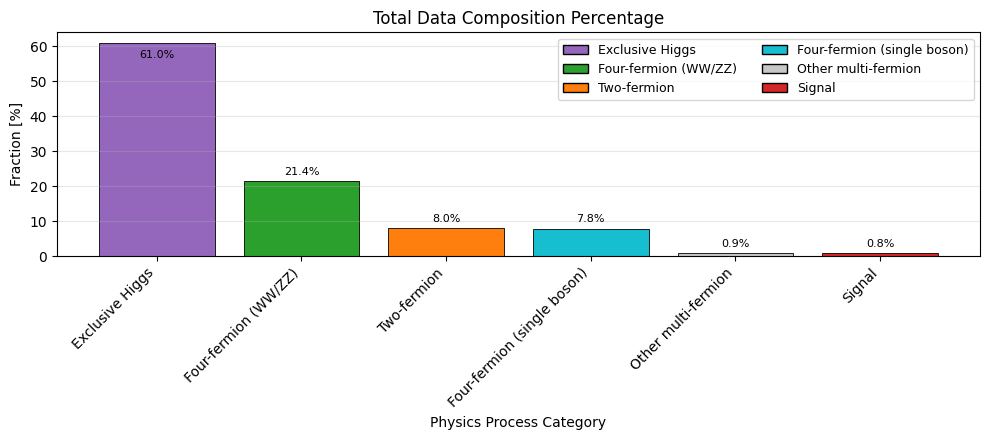

In [38]:
# This will the dataframe composition without aggregating
composition_full = process_group_composition_full(dataset_df)
print(composition_full)


acc_eff = acceptance_efficiency(composition_full)



plot_composition(
    composition_full,
    annotation=True,
    title="Total Data Composition Percentage",
    save_path="total_data_composition.png",
)


                             events  percentage
process_group                                  
Exclusive Higgs                8809   80.016350
Signal                         1270   11.536016
Four-fermion (WW/ZZ)            694    6.303933
Four-fermion (single boson)     235    2.134617
Two-fermion                       1    0.009083
0.009083477155054955


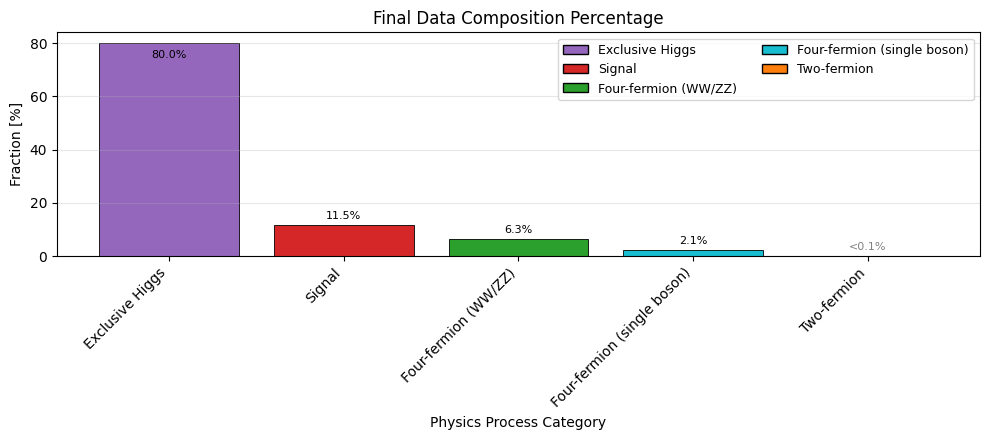

In [39]:
# This will the dataframe composition without aggregating
final_composition_full = process_group_composition_full(final_df)
print(final_composition_full)



final_acc_eff = acceptance_efficiency(final_composition_full)



plot_composition(
    final_composition_full,
    annotation=True,
    title="Final Data Composition Percentage",
    save_path="final_data_composition.png",
)


In [40]:
surviving_processes = dataset_df["process_id"].unique()
print(dataset_df.groupby("process_id").size())
new_cleaned_df = cleaned_df[
    cleaned_df["process_id"].isin(surviving_processes)
].copy()
print(surviving_processes)
new_cleaned_df

process_id
402101     396
402102     157
402103      90
402104     424
402105     844
          ... 
500326      78
500330      60
500334      88
500338     491
signal    2315
Length: 116, dtype: int64
['402215' '402140' '402195' '402156' '402213' '402161' '402715' '402702'
 '402163' '402714' '402209' '402158' '402174' '402197' '402194' '402217'
 '402726' '410004' '402732' '402143' '402721' '402175' '402727' '402101'
 '402720' '402157' '402211' '402177' '402725' '402102' '402733' '410005'
 '402703' '402731' '402109' '402145' '402162' '402173' '402105' '410003'
 '402138' '402193' '402108' '410002' '402104' '402738' '402176' '402144'
 '402142' '402713' '402210' '402739' '410001' '402212' '402196' '402137'
 '402139' '402180' '410006' '402719' '402181' '402103' '402199' '402737'
 '402216' '402198' '402107' '402160' '402191' '402141' '402159' '402179'
 '402155' '402214' '402701' '402192' 'signal' '402311' '500334' '500074'
 '500086' '500314' '500322' '402315' '402301' '500310' '500078' '402

,process_type,pol,process_id,xsect_pb,xsect_error_pb,nGenerated,nSelected,weight,process_group
1,e1e1h_az,eL.pR,402107,0.027037,0.000035,10000,479,0.000676,Exclusive Higgs
2,e1e1h_bb,eL.pR,402101,10.284808,0.013270,10000,657,0.257120,Exclusive Higgs
3,e1e1h_cc,eL.pR,402102,0.510706,0.000659,10000,266,0.012768,Exclusive Higgs
4,e1e1h_dd,eL.pR,402703,0.000919,0.000001,10000,89,0.000023,Exclusive Higgs
5,e1e1h_e2e2,eL.pR,402109,0.003852,0.000005,9600,9423,0.000100,Exclusive Higgs
...,...,...,...,...,...,...,...,...,...
107,4f-lcfi_zz_cccc,eL.pR,500334,56.504134,0.050000,2442,165,5.784617,Four-fermion (single boson)
108,4f-lcfi_zz_dddd,eL.pR,500322,70.800256,0.062300,6400,150,2.765635,Four-fermion (single boson)
109,4f-lcfi_zz_ssss,eL.pR,500330,70.800256,0.062300,6400,122,2.765635,Four-fermion (single boson)
110,4f-lcfi_zz_uuuu,eL.pR,500326,56.476488,0.048900,6400,138,2.206113,Four-fermion (single boson)


# Cuts and Figure Of Merit (FOM)

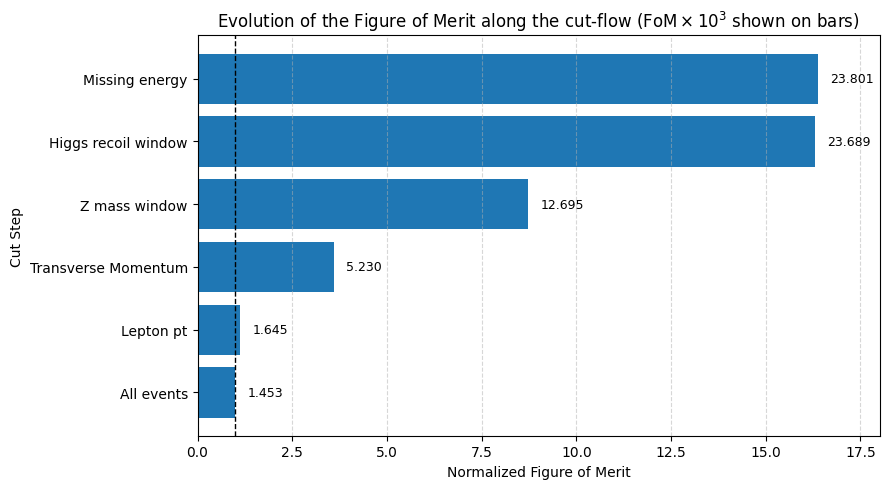

In [41]:
x = list(history_df.keys())
y= foms
y_norm = [v / y[0] for v in y]

plt.figure(figsize=(9, 5))
plt.barh(x, y_norm)

plt.ylabel("Cut Step")
plt.xlabel("Normalized Figure of Merit")
plt.title(r"Evolution of the Figure of Merit along the cut-flow ($\mathrm{FoM}\times10^{-3}$ shown on bars)")

plt.axvline(1.0, color="black", linestyle="--", linewidth=1)
plt.grid(axis="x", linestyle="--", alpha=0.5)

scale = 1e3

xmax = max(y_norm)
plt.xlim(0, xmax * 1.1)

for i, (yn, yabs) in enumerate(zip(y_norm, y)):
    plt.text(
        yn + 0.02 * xmax,
        i,
        f"{yabs * scale:.3f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.savefig("fom_cutflow.png", dpi=300)
plt.show()



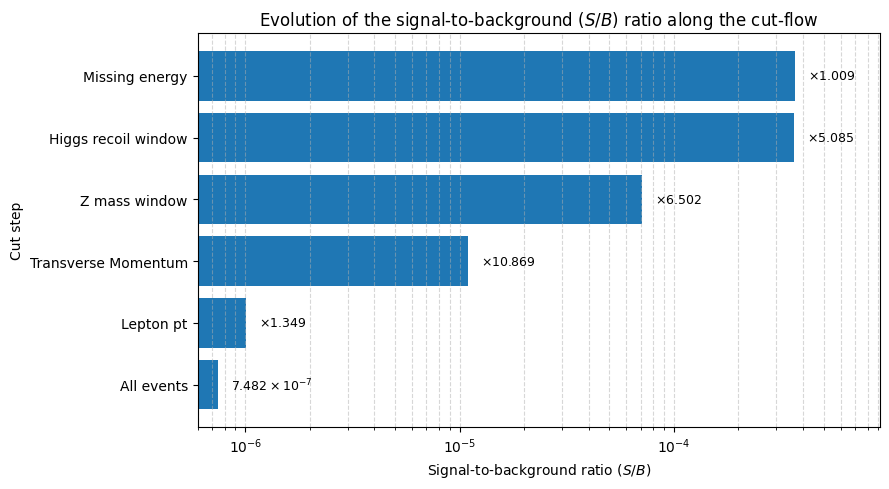

In [42]:
sb = np.asarray(sbs, dtype=float)

ratio_sb = np.ones_like(sb)
ratio_sb[1:] = sb[1:] / sb[:-1]

def format_ratio_latex(r):
    if abs(r - 1) < 1e-3:
        return rf"$\times {r:.3e}$"
    else:
        return rf"$\times {r:.3f}$"




plt.figure(figsize=(9, 5))
plt.barh(x, sb, color="tab:blue")

plt.xlabel(r"Signal-to-background ratio ($S/B$)")
plt.ylabel("Cut step")
plt.title(r"Evolution of the signal-to-background ($S/B$) ratio along the cut-flow")

plt.xscale("log")
plt.grid(axis="x", linestyle="--", alpha=0.5, which="both")

xmin = sb.min() * 0.8
xmax = sb.max() * 2.5
plt.xlim(xmin, xmax)

for i, (sbi, ri) in enumerate(zip(sb, ratio_sb)):
    if i == 0:
        label = to_latex_scientific(sbi, sig=3)
    else:
        label = format_ratio_latex(ri)

    plt.text(
        sbi * 1.15,
        i,
        label,
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.savefig("sb_cutflow_ratio.png")
plt.show()


In [43]:

# Define bin edges explicitly
bin_edges = np.linspace(0, 300, 60 + 1)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

def bins_unc(df, col, range_min=0, range_max=300, bins=60):

    # Define bin edges explicitly
    bin_edges = np.linspace(range_min, range_max, bins + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # -------------------------------------------------
    # Compute total (signal + background) bin contents
    # and MC statistical uncertainties
    # -------------------------------------------------
    
    all_vals = df[col].to_numpy()
    all_w = df["weight"].to_numpy()
    
    # Bin contents: sum of weights
    bin_contents, _ = np.histogram(
        all_vals,
        bins=bin_edges,
        weights=all_w,
    )
    
    # Bin uncertainties: sqrt(sum of w^2)
    bin_uncertainties, _ = np.histogram(
        all_vals,
        bins=bin_edges,
        weights=all_w**2,
    )
    bin_uncertainties = np.sqrt(bin_uncertainties)
    relative_unc = bin_uncertainties / np.maximum(bin_contents, 1e-12)
    print(f"Max {col} relative uncertainty:", relative_unc.max())

    return bin_centers, bin_contents, bin_uncertainties

## 1-D Histogram Function

In [44]:
print(dataset_df["process_group"].value_counts())

process_group
Exclusive Higgs                166475
Four-fermion (WW/ZZ)            58483
Two-fermion                     21897
Four-fermion (single boson)     21372
Other multi-fermion              2393
Signal                           2315
Name: count, dtype: int64


# Invariant Mass

In [62]:
def plot_weighted_histogram_with_signal(
    df,
    *,
    variable,
    bins=50,
    range=None,
    weight_col="weight",
    group_col="process_group",
    signal_tag="Signal",
    signal_scale=20.0,
    vline=None,
    vlabel=rf"$m_h = {h_mass:.0f}$ GeV",
    title=None,
    xlabel=None,
    ylabel="Events",
    save_path,
):
    bin_edges = np.histogram_bin_edges(df[variable], bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_widths = np.diff(bin_edges)

    contents = {}
    errors = {}

    for g in df[group_col].unique():
        sub = df[df[group_col] == g]
        x = sub[variable].values
        w = sub[weight_col].values

        hist, _ = np.histogram(x, bins=bin_edges, weights=w)
        hist_w2, _ = np.histogram(x, bins=bin_edges, weights=w**2)

        contents[g] = hist
        errors[g] = np.sqrt(hist_w2)

    # Separate background and signal
    backgrounds = [g for g in contents if g != signal_tag]
    signal = signal_tag if signal_tag in contents else None

    # Sort backgrounds by total contribution (largest at bottom)
    backgrounds = sorted(
        backgrounds,
        key=lambda g: contents[g].sum(),
        reverse=True,
    )

    fig, ax = plt.subplots(figsize=(8, 6))

    # ────── Stack backgrounds ──────
    bottom = np.zeros(len(bin_centers))
    for g in backgrounds:
        print(g)
        ax.bar(
            bin_centers,
            contents[g],
            width=bin_widths,
            bottom=bottom,
            color=process_colors(g),
            label=g,
            alpha=0.85,
            align="center",
        )
        bottom += contents[g]

    # Background uncertainty band
    bkg_err = np.sqrt(np.sum([errors[g]**2 for g in backgrounds], axis=0))
    ax.errorbar(
        bin_centers,
        bottom,
        yerr=bkg_err,
        fmt="none",
        ecolor="black",
        elinewidth=1.2,
        capsize=2,
        label="MC. stat. unc.",
    )

    # ────── Signal overlay ──────
    if signal is not None:
        ax.step(
            bin_centers,
            contents[signal] * signal_scale,
            where="mid",
            linewidth=2.2,
            linestyle="--",
            color=process_colors("Signal")
,
            label=rf"Signal × {signal_scale:g}",
        )

        # ────── Higgs mass reference line ──────
    if vline is not None:
        ax.axvline(
            vline,
            color="black",
            linestyle=":",
            linewidth=1.8,
            label=vlabel,
        )
    
    ax.set_xlabel(xlabel or variable)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    if save_path:
        print(f"Saved figure: {save_path}")
        plt.savefig(save_path, dpi=300)
    plt.show()


In [63]:
sig_max = 100_000
sig_min = 1000

Two-fermion
Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Other multi-fermion
Saved figure: invariant_mass_dataset.png


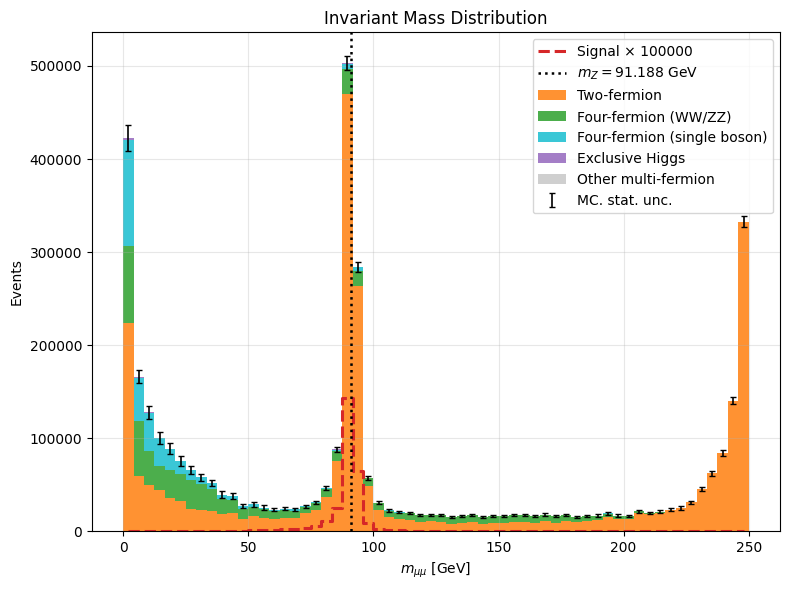

Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Two-fermion
Saved figure: invariant_mass_final.png


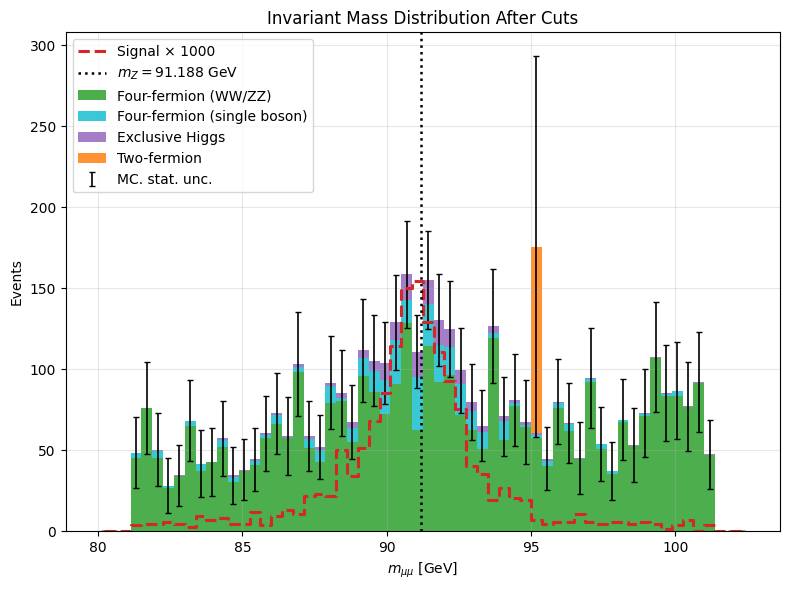

In [64]:
plot_weighted_histogram_with_signal(
    dataset_df,
    variable="invMass",
    bins=60,
    range=(0, 250),
    signal_scale=sig_max,
    vline=z_mass,
    vlabel=rf"$m_Z = {z_mass:}$ GeV",
    title=r"Invariant Mass Distribution",
    xlabel=r"$m_{\mu\mu}$ [GeV]",
    save_path="invariant_mass_dataset.png"
)
plot_weighted_histogram_with_signal(
    final_df,
    variable="invMass",
    bins=60,
    range=(80, 102.5),
    signal_scale=sig_min,
    vline=z_mass,
    vlabel=rf"$m_Z = {z_mass:}$ GeV",
    title=r"Invariant Mass Distribution After Cuts",
    xlabel=r"$m_{\mu\mu}$ [GeV]",
    save_path="invariant_mass_final.png"
)

# Invariant Mass
#(0, 250)
#(80, 102.5)

# Recoil Mass

Two-fermion
Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Other multi-fermion
Saved figure: recoil_mass_dataset.png


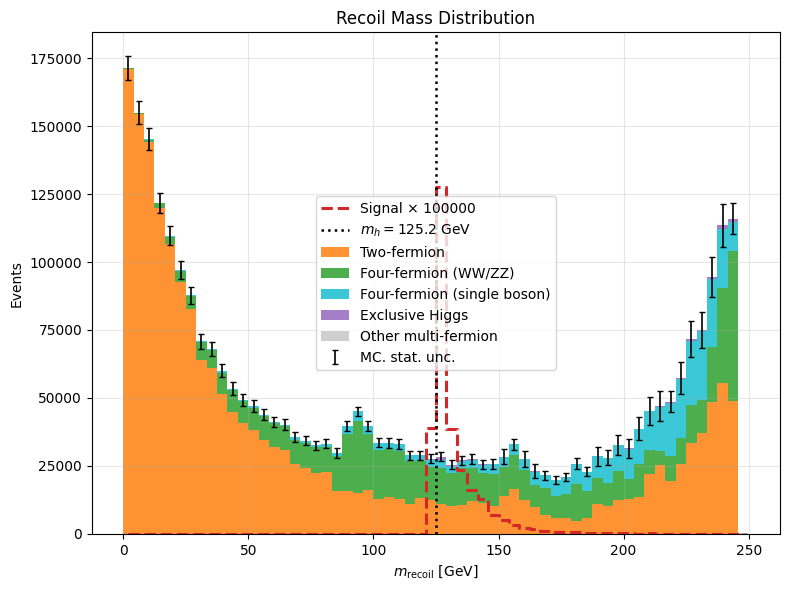

Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Two-fermion
Saved figure: recoil_mass_final.png


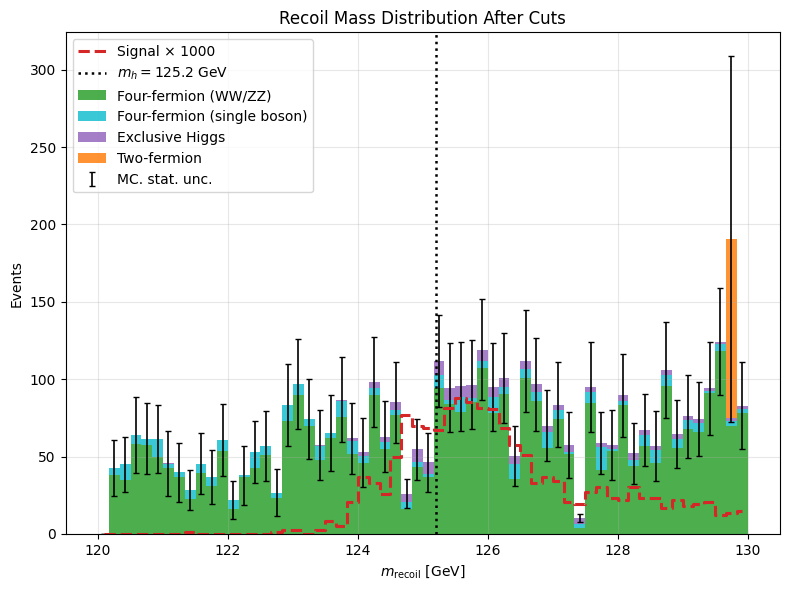

In [65]:
plot_weighted_histogram_with_signal(
    dataset_df,
    variable="recoilMass",
    bins=60,
    range=(0, 250),
    signal_scale=sig_max,
    vline=h_mass,
    vlabel=rf"$m_h = {h_mass}$ GeV",
    title=r"Recoil Mass Distribution",
    xlabel=r"$m_{\mathrm{recoil}}$ [GeV]",
    save_path="recoil_mass_dataset.png"
)
plot_weighted_histogram_with_signal(
    final_df,
    variable="recoilMass",
    bins=60,
    range=(120, 130),
    signal_scale=sig_min,
    vline=h_mass,
    vlabel=rf"$m_h = {h_mass}$ GeV",
    title=r"Recoil Mass Distribution After Cuts",
    xlabel=r"$m_{\mathrm{recoil}}$ [GeV]",
    save_path="recoil_mass_final.png"
)
#(0, 250)
#(120, 130)

## Transverse Energy of Two Muons Histogram

Two-fermion
Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Other multi-fermion
Saved figure: transverse_energy_hist.png


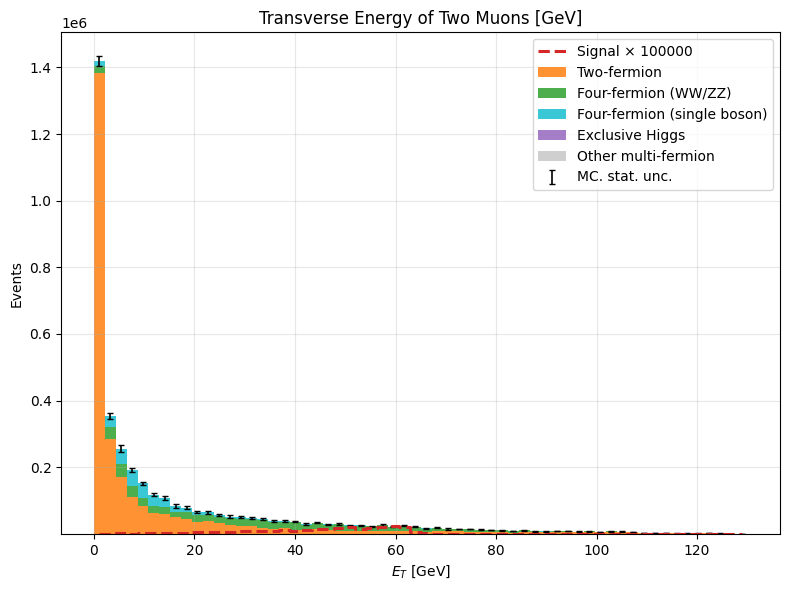

Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Two-fermion
Saved figure: transverse_energy_hist.png


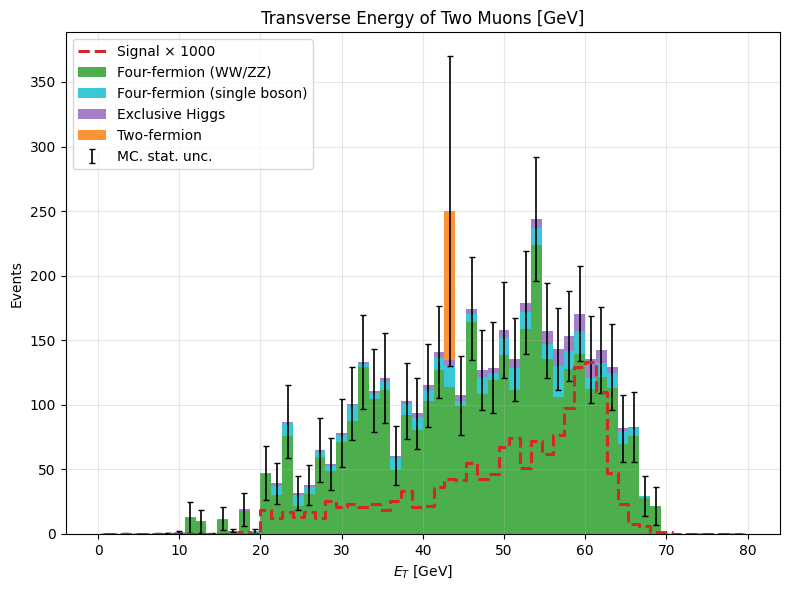

In [66]:
plot_weighted_histogram_with_signal(
    dataset_df,
    variable="dimuon_pt",
    bins=60,
    range=(0, 130),
    signal_scale=sig_max,
    xlabel=r"$E_{T}$ [GeV]",
    title="Transverse Energy of Two Muons [GeV]",
    save_path="transverse_energy_hist.png"
)
plot_weighted_histogram_with_signal(
    final_df,
    variable="dimuon_pt",
    bins=60,
    range=(0, 80),
    signal_scale=sig_min,
    xlabel=r"$E_{T}$ [GeV]",
    title="Transverse Energy of Two Muons [GeV]",
    save_path="transverse_energy_hist.png"
)

### Highest and Lowest Transverse energy muons

Two-fermion
Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Other multi-fermion
Saved figure: high_muon_energy.png


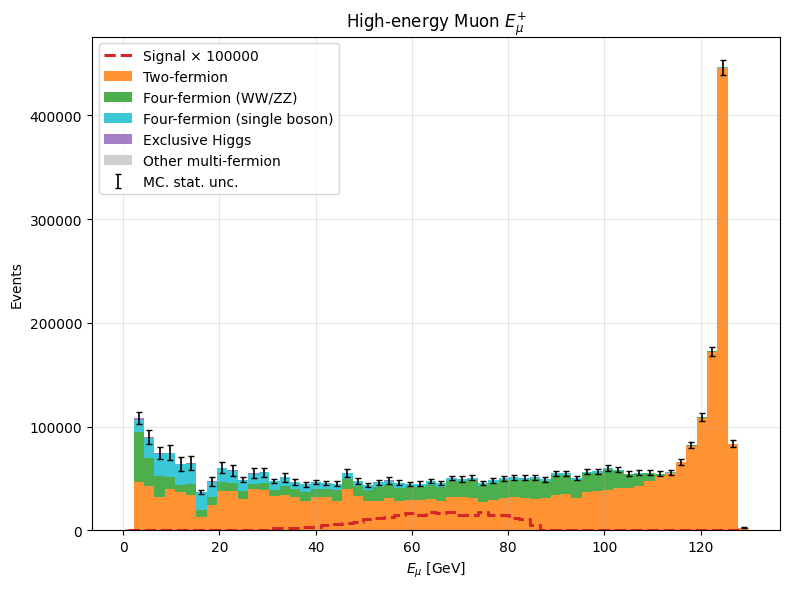

Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Two-fermion
Saved figure: high_muon_energy.png


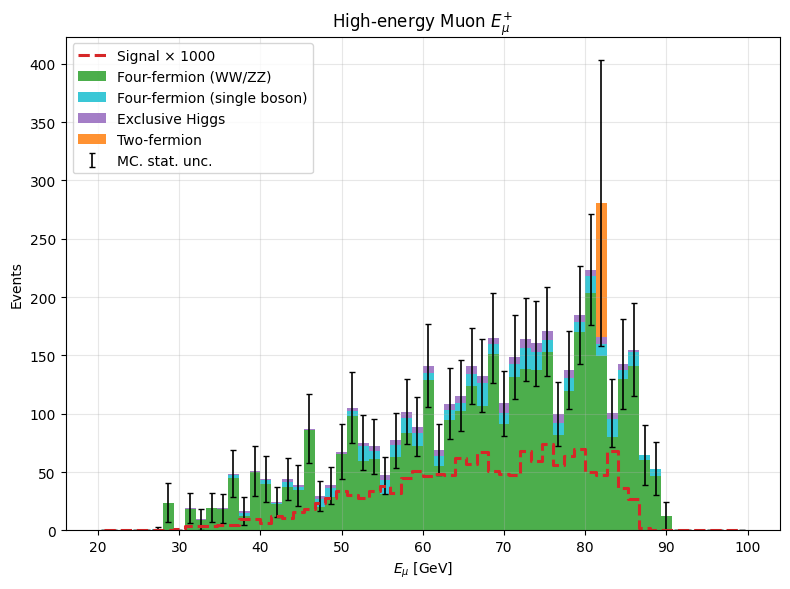

In [67]:
plot_weighted_histogram_with_signal(
    dataset_df,
    variable="mu1_E",
    bins=60,
    range=(0, 130),
    signal_scale=sig_max,
    xlabel=r"$E_\mu$ [GeV]",
    title=r"High-energy Muon $E_\mu^{+}$",
    save_path="high_muon_energy.png"
)
plot_weighted_histogram_with_signal(
    final_df,
    variable="mu1_E",
    bins=60,
    range=(20, 100),
    signal_scale=sig_min,
    xlabel=r"$E_\mu$ [GeV]",
    title=r"High-energy Muon $E_\mu^{+}$",
    save_path="high_muon_energy.png"
)

Two-fermion
Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Other multi-fermion
Saved figure: low_muon_energy.png


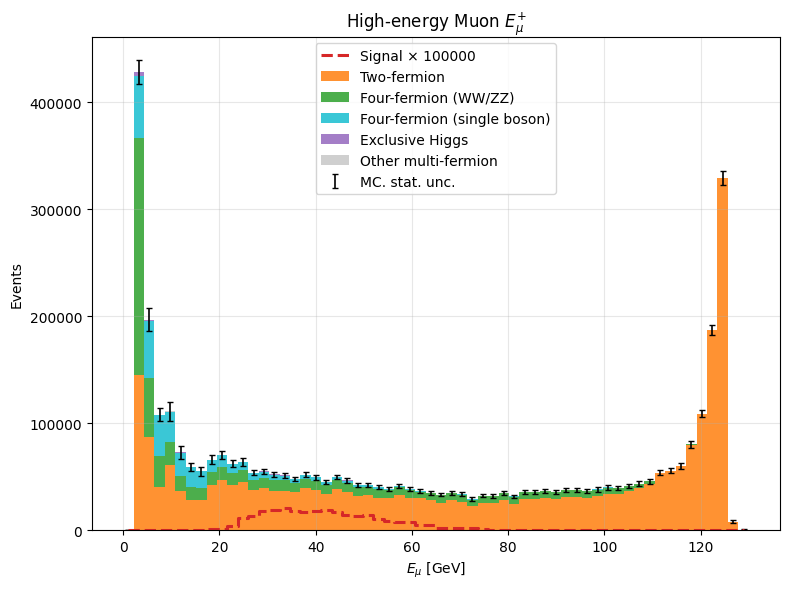

Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Two-fermion
Saved figure: low_muon_energy.png


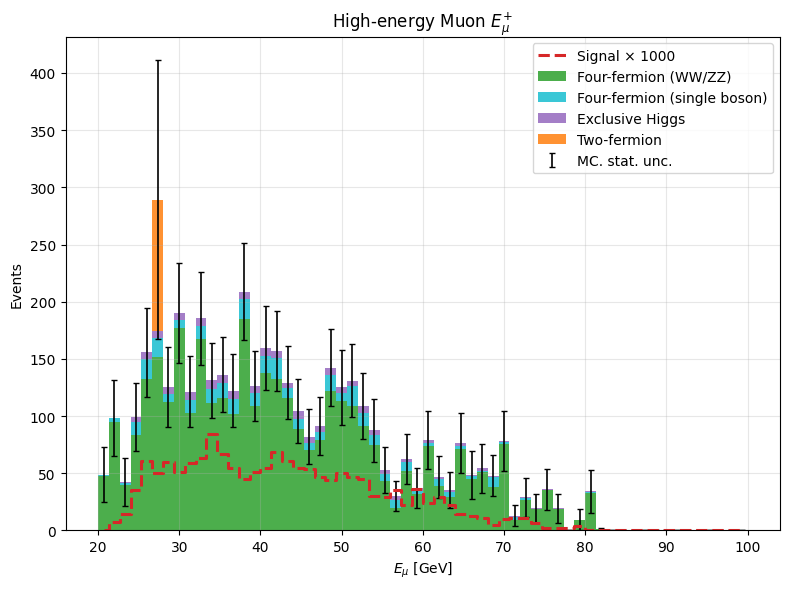

In [68]:
plot_weighted_histogram_with_signal(
    dataset_df,
    variable="mu2_E",
    bins=60,
    range=(0, 130),
    signal_scale=sig_max,
    xlabel=r"$E_\mu$ [GeV]",
    title=r"High-energy Muon $E_\mu^{+}$",
    save_path="low_muon_energy.png"
)
plot_weighted_histogram_with_signal(
    final_df,
    variable="mu2_E",
    bins=60,
    range=(20, 100),
    signal_scale=sig_min,
    xlabel=r"$E_\mu$ [GeV]",
    title=r"High-energy Muon $E_\mu^{+}$",
    save_path="low_muon_energy.png"
)

### Missing Energy Histogram

Two-fermion
Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Other multi-fermion
Saved figure: missing_energy.png


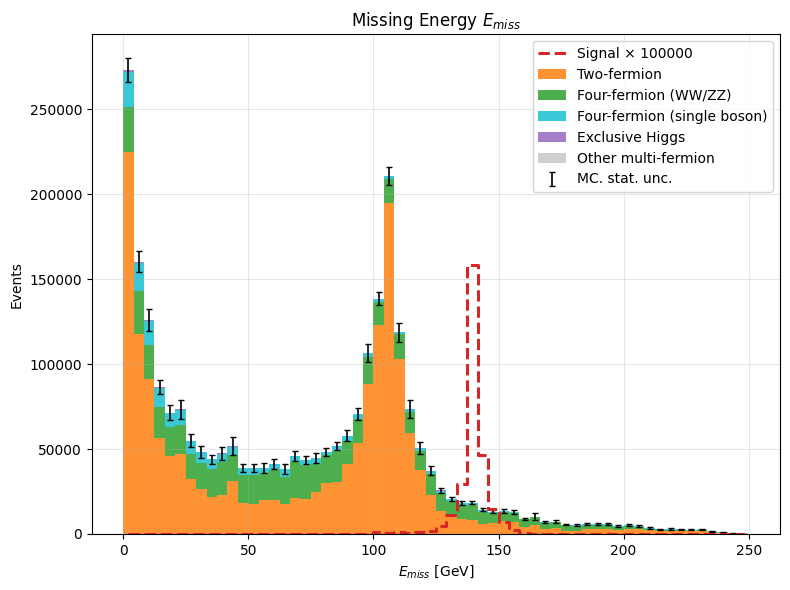

Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Two-fermion
Saved figure: missing_energy_final.png


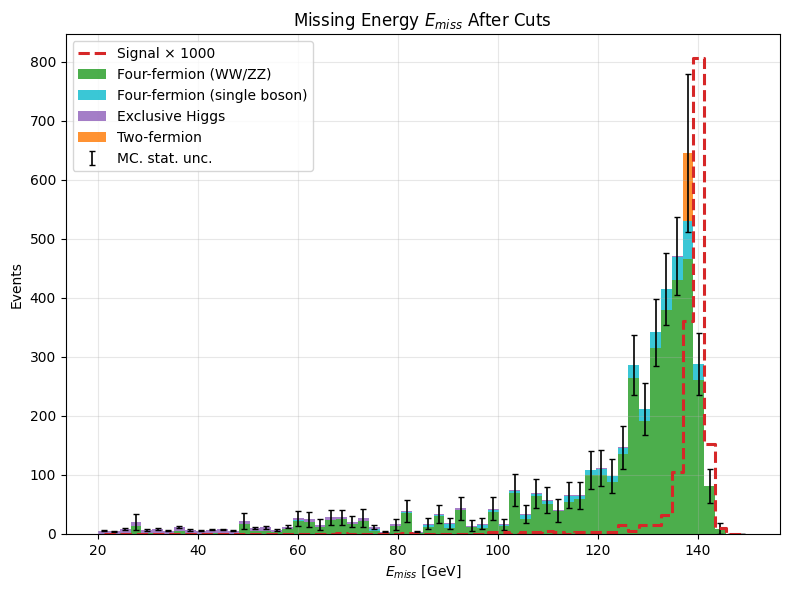

In [69]:
plot_weighted_histogram_with_signal(
    dataset_df,
    variable="missingEnergy",
    bins=60,
    range=(0, 250),
    signal_scale=sig_max,
    xlabel=r"$E_{miss}$ [GeV]",
    title=r"Missing Energy $E_{miss}$",
    save_path="missing_energy.png"
)
plot_weighted_histogram_with_signal(
    final_df,
    variable="missingEnergy",
    bins=60,
    range=(20, 150),
    signal_scale=sig_min,
    xlabel=r"$E_{miss}$ [GeV]",
    title=r"Missing Energy $E_{miss}$ After Cuts",
    save_path="missing_energy_final.png"
)

## Muon Pair Energy Distribution Histogram

Two-fermion
Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Other multi-fermion
Saved figure: stacked_total_energy.png


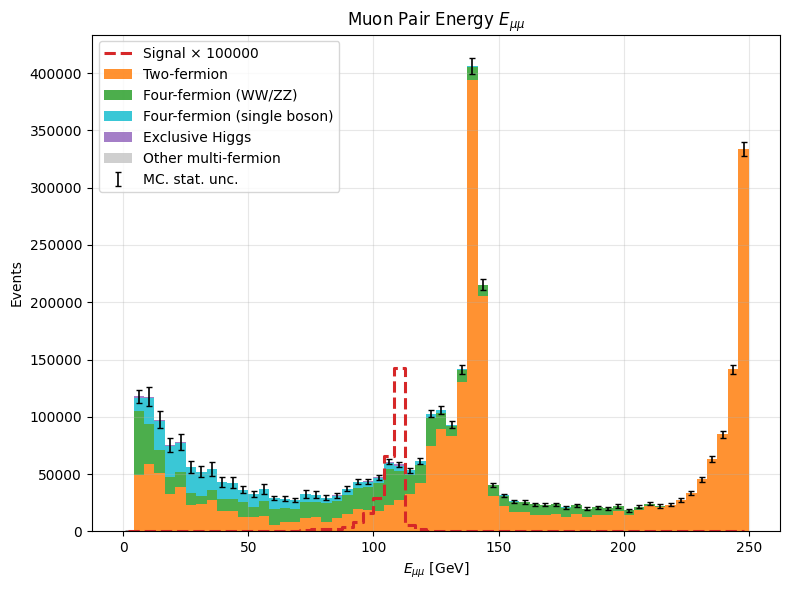

Four-fermion (WW/ZZ)
Four-fermion (single boson)
Exclusive Higgs
Two-fermion
Saved figure: final_total_energy.png


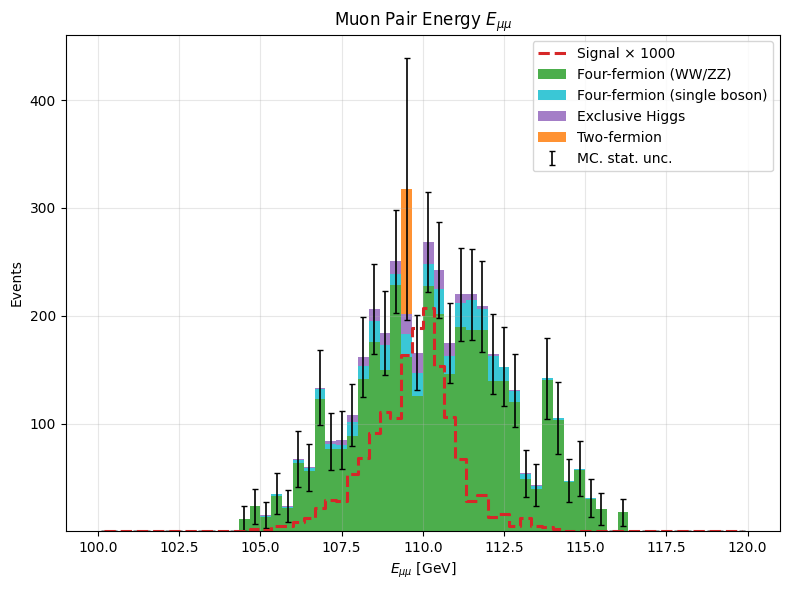

In [70]:
plot_weighted_histogram_with_signal(
    dataset_df,
    variable="totalEnergy",
    bins=60,
    range=(0, 250),
    signal_scale=sig_max,
    xlabel=r"$E_{\mu\mu}$ [GeV]",
    title=r"Muon Pair Energy $E_{\mu\mu}$",
    save_path="stacked_total_energy.png"
)
plot_weighted_histogram_with_signal(
    final_df,
    variable="totalEnergy",
    bins=60,
    range=(100, 120),
    signal_scale=sig_min,
    xlabel=r"$E_{\mu\mu}$ [GeV]",
    title=r"Muon Pair Energy $E_{\mu\mu}$",
    save_path="final_total_energy.png"
)

### Crossing Variables

In [53]:
def plot_weighted_2d_crossing_with_signal(
    df,
    *,
    xvar,
    yvar,
    bins=(50, 50),
    xrange=None,
    yrange=None,
    weight_col="weight",
    group_col="process_group",
    signal_tag="Signal",
    signal_scale=1.0,
    cmap="viridis",
    title=None,
    xlabel=None,
    ylabel=None,
    save_path=None,
):
    """
    2D crossing plot of two variables.
    Backgrounds are shown as a weighted density,
    signal is overlaid using the same process color scheme.
    """

    fig, ax = plt.subplots(figsize=(7.5, 6))

    # ────── Separate background and signal ──────
    df_bkg = df[df[group_col] != signal_tag]
    df_sig = df[df[group_col] == signal_tag]

    # ────── Background density (summed over all backgrounds) ──────
    h = ax.hist2d(
        df_bkg[xvar],
        df_bkg[yvar],
        bins=bins,
        range=[xrange, yrange],
        weights=df_bkg[weight_col],
        cmap=cmap,
    )

    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label("Weighted events")

    # ────── Signal overlay ──────
    if not df_sig.empty:
        ax.scatter(
            df_sig[xvar],
            df_sig[yvar],
            s=12,
            c=process_colors("Signal"),
            alpha=0.85,
            label=(
                rf"Signal × {signal_scale:g}"
                if signal_scale != 1.0
                else "Signal"
            ),
        )

    # ────── Labels & styling ──────
    ax.set_xlabel(xlabel or xvar)
    ax.set_ylabel(ylabel or yvar)

    if title:
        ax.set_title(title)

    ax.legend(frameon=True)
    ax.grid(alpha=0.3)

    plt.tight_layout()

    if save_path:
        print(f"Saved figure: {save_path}")
        plt.savefig(save_path, dpi=300)

    plt.show()


In [54]:
variables = [
    "recoilMass",
    "invMass",
    "missingEnergy",
    "totalEnergy",
]


dataset_df[variables].corr()


,recoilMass,invMass,missingEnergy,totalEnergy
recoilMass,1.000000,-0.752361,0.169696,-0.939461
invMass,-0.752361,1.000000,-0.295909,0.906413
missingEnergy,0.169696,-0.295909,1.000000,-0.238853
totalEnergy,-0.939461,0.906413,-0.238853,1.000000


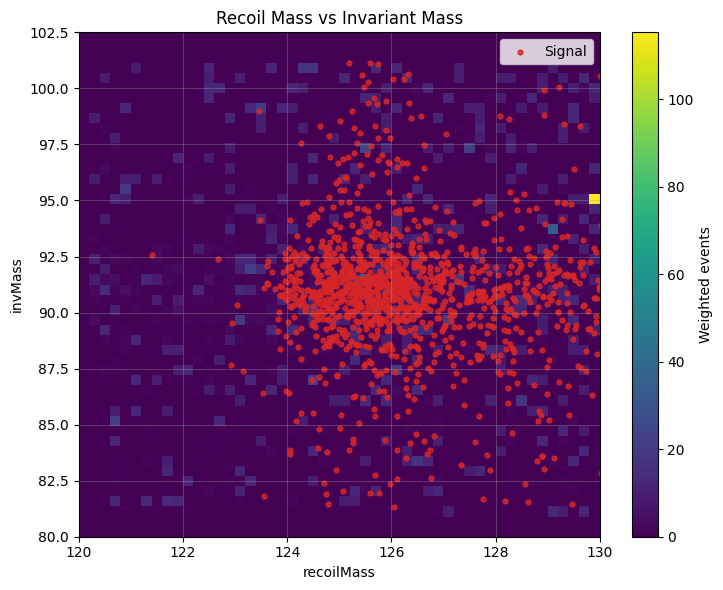

In [55]:
# Invariant Mass
#(0, 250)
#(80, 102.5)

# Recoil Mass
# (0, 250)
# (120, 130)

plot_weighted_2d_crossing_with_signal(
    df=final_df,
    xvar="recoilMass",
    yvar="invMass",
    bins=(50, 50),
    xrange=(120,130),
    yrange=(80,102.5),
    weight_col="weight",
    group_col="process_group",
    signal_tag="Signal",
    signal_scale=1.0,
    cmap="viridis",
    title=r"Recoil Mass vs Invariant Mass",
    xlabel=None,
    ylabel=None,
    save_path=None,
)

In [56]:
"""
for i, x in enumerate(variables):
    for y in variables[i+1:]:
        plot_cross_variables(
            variant_plus_signal,
            x_col=x,
            y_col=y,
            save_path=f"{y}_vs_{x}.png",
            show=True,
        )
"""

'\nfor i, x in enumerate(variables):\n    for y in variables[i+1:]:\n        plot_cross_variables(\n            variant_plus_signal,\n            x_col=x,\n            y_col=y,\n            save_path=f"{y}_vs_{x}.png",\n            show=True,\n        )\n'

In [57]:
"""
for i, x in enumerate(variables):
    for y in variables[i+1:]:
        plot_cross_variables(
            final_df,
            x_col=x,
            y_col=y,
            save_path=f"{y}_vs_{x}.png",
            show=True,
        )
"""

'\nfor i, x in enumerate(variables):\n    for y in variables[i+1:]:\n        plot_cross_variables(\n            final_df,\n            x_col=x,\n            y_col=y,\n            save_path=f"{y}_vs_{x}.png",\n            show=True,\n        )\n'